# Merge and analyze overnight photometry trials

This script will take individual overnight fiber photometry recording sessions (several hours or more each) with simultaneous behavioral data recorded from a FED3 device. The script 1) combines data across sessions and 2) performs analysis of the combined data.

The individual trials should be together in a directory as .pkl files (output from "Single_Overnight_FED3.ipynb"), each file name beginning with 'AllData_'.

This script outputs a .pkl file containing the merged data ('AllTrialsData.pkl'), and several graphs.

As measures of activity, this script uses both dF/F0 (change in activity relative to pre-stimulus period) and z-scored dF/F0 (i.e. normalized to pre-stimulus signal variance), as well as taking a moving mean of these signals to remove noise and fast-timescale signal fluctuations.

In [1]:
## Take all photometry trials in a directory, merge, and save to file
from tkinter.filedialog import askdirectory
from tkinter import Tk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
from os import listdir
from os.path import isfile, join
from itertools import compress
import datetime
from functions.date_range import date_range #in functions folder
from matplotlib.dates import DateFormatter
import seaborn as sns
import pingouin as pg
from matplotlib import colors
import matplotlib.patches as patches

#######################################
# Set these variables
ConditionsToPlot = ['6pm-8am fast','fed']#['6pm-8am fast','fed'] # other common options:, "choc 6pm calorie-free"]#,"3pm-8am fast", "12pm-8am fast"]#["6-8 fast Saline", "6-8 fast CNO", "FR1 6-8 fast Saline", "FR1 6-8 fast CNO"]#["6pm-8am fast", "fed", "sham fast", "FR1 6-8 fast", "FR1 fed"]#["6pm-8am fast", "fed", "3pm-8am fast", "12pm-8am fast"] #, "6pm-8am water dep"]
ColorsToUse = ['green','purple'] # other common options:,'darkred']#,'goldenrod','darkred']#['orange','purple','goldenrod','violet']#['green','purple','goldenrod','springgreen','violet']#['green','purple','goldenrod','darkred'] #,'blue'],#orange
MovingMeanVals = [1,5,10,30] # values over which to take moving mean for plots, in mins

# Select only trials beginning at a particular time
# Enter 'All' to include all trials, or number for trials starting at specific hour (in Zeitgeber time - lights on = 0)
TrialsBeginning = 'All'#6
#######################################

plt.rcParams['figure.figsize'] = [9,10.5] # Make default figure size larger.
plt.rcParams['axes.xmargin'] = 0          # Make default margin on x axis zero.
plt.rcParams.update({'font.size': 16})

In [2]:
# Open a dialog box to select the directory to be analyzed
window = Tk()
window.wm_attributes('-topmost', 1)
window.withdraw()
Dir2 = askdirectory(parent = window)
os.chdir(Dir2 + '/')

# List all files in directory
onlyfiles = [f for f in listdir(Dir2) if isfile(join(Dir2, f))]

# Find .pkl files containing 'AllData_'
pklFiles=[]
for i in range(len(onlyfiles)):
    if onlyfiles[i].find('AllData_')>-1 and onlyfiles[i].find('.pkl')>-1:
        pklFiles.append(onlyfiles[i])

In [3]:
### Create 'AllTrials' dict, and dataframes within, to contain merged data
# Initialize 'AllTrials' dictionary
my_cols = pd.MultiIndex(levels = [[],[],[]], codes = [[],[],[]],
                            names = [u'MouseID',u'MouseTrialID',u'Stim'])

AllTrials = {'Raw':pd.DataFrame(columns = my_cols), 'Raw_DS':pd.DataFrame(columns = my_cols),
                'dFF0':pd.DataFrame(columns = my_cols),'z-score':pd.DataFrame(columns = my_cols), 
                'Condition':[], 'StartTime':[], 'Events':pd.DataFrame(), 'AnalysisFile':[], 'SamplingRate':[],
                'DownSamplingRate':[], 'MouseID':[], 'MouseTrialID':[], 'FEDClockOffset':[],
                'FED_data':{}, 'Pokes_Pellets':{'pokes_raw':{},'pokes_cum':{},'pellets_raw':{},'pellets_cum':{},'poke_activity':{}},
                'Poke_Rate':pd.DataFrame(columns = my_cols), 'PokeBouts':{}, 'Poke_Bout_Aligned_Activity':{}}
TracesToSave = ('Raw','Raw_DS','dFF0','z-score')
MetaToSave = ('Condition','StartTime','AnalysisFile','SamplingRate','DownSamplingRate','FEDClockOffset')

# Loop through trials (=files)
for i in pklFiles:
    with open(i, 'rb') as f:
        TrialData = pickle.load(f)
        # Find MouseID and TrialID from the file name
        MouseID = i[i.find('_')+1:i.find('-')]
        TrialID = i[i.find('-')+1:i.rfind('.')]
        MouseTrialID = MouseID+'_'+TrialID
        TrialData['Events'].columns = [MouseTrialID]

        # For each type of metadata, save to AllTrials
        for j in MetaToSave:
            if type(TrialData[j]) == list: # legacy! in previous versions of single trial script, condition name was saved as 1-element list.
                AllTrials[j].append(TrialData[j][0])
            else:
                AllTrials[j].append(TrialData[j])

        # For each trace type, save to AllTrials
        trial_cols = pd.MultiIndex.from_arrays([[MouseID],[MouseTrialID],[AllTrials['Condition'][-1]]],
                                names = ['MouseID','MouseTrialID','Stim'])
        for j in TracesToSave:
            # In previous versions of single trial script, time was not converted to ZT. If this is the case, then convert by subtracting 6h:
            if TrialData['AnalysisFile'] not in ['Single_Overnight_Analysis', 'Single_Overnight_FED3']:
                TrialData[j].index = [k - datetime.timedelta(hours=6) for k in list(TrialData[j].index)]
            ToAdd = pd.DataFrame(list(TrialData[j]['GCaMP']), index = TrialData[j].index, 
                                columns = trial_cols)
            AllTrials[j] = pd.concat([AllTrials[j],ToAdd],axis=1)
            AllTrials[j] = AllTrials[j].sort_index()
        
        # Add Events and other data
        # As above, convert to ZT by subtracting 6h from event labels if necessary
        if TrialData['AnalysisFile'] not in ['Single_Overnight_Analysis', 'Single_Overnight_FED3']:
            TrialData['Events'].index = [k - datetime.timedelta(hours = 6) for k in TrialData['Events'].index]
        AllTrials['Events'] = pd.concat([AllTrials['Events'],TrialData['Events']],axis=1)
        AllTrials['Events'] = AllTrials['Events'].sort_index()
        AllTrials['MouseID'].append(MouseID)
        AllTrials['MouseTrialID'].append(MouseTrialID)

        #now add FED dicts
        AllTrials['FED_data'][MouseTrialID] = TrialData['FED_data']
        for p in ['pokes_raw','pokes_cum','pellets_raw','pellets_cum']:
            AllTrials['Pokes_Pellets'][p][MouseTrialID] = TrialData['Pokes_Pellets'][p]
        
        my_cols = pd.MultiIndex(levels = [[],[]], codes = [[],[]],
                            names = [u'MouseTrialID',u'Poke_Time'])
        
        # add poke/pellet data
        for p in TrialData['Pokes_Pellets']['poke_activity'].keys():
            if i==pklFiles[0]:
                AllTrials['Pokes_Pellets']['poke_activity'][p] = pd.DataFrame(columns = my_cols)
            ToAdd = pd.DataFrame(TrialData['Pokes_Pellets']['poke_activity'][p])
            ToAdd.columns = [np.array([MouseTrialID]*len(TrialData['Pokes_Pellets']['poke_activity'][p].columns)),
                             np.array(TrialData['Pokes_Pellets']['poke_activity'][p].columns)]
            AllTrials['Pokes_Pellets']['poke_activity'][p] = pd.concat([AllTrials['Pokes_Pellets']['poke_activity'][p], ToAdd], axis=1)
        
        TrialData['Poke_Rate'].columns = [MouseTrialID]
        AllTrials['Poke_Rate'] = pd.concat([AllTrials['Poke_Rate'],TrialData['Poke_Rate']],axis=1)
        AllTrials['PokeBouts'][MouseTrialID] = TrialData['PokeBouts']['PokeBouts']
        
        # add poke bout-aligned activity
        my_cols = pd.MultiIndex(levels = [[],[]], codes = [[],[]],
                    names = [u'MouseTrialID',u'Bout_Time'])
        for p in TrialData['PokeBouts']['Poke_Bout_Aligned_Activity'].keys():
            if p not in list(AllTrials['Poke_Bout_Aligned_Activity'].keys()):
                AllTrials['Poke_Bout_Aligned_Activity'][p] = pd.DataFrame(columns = my_cols)
            # change columns to add MouseTrialID to multiindex:
            old_col = TrialData['PokeBouts']['Poke_Bout_Aligned_Activity'][p].columns.to_frame()
            old_col.insert(0, 'MouseTrialID', np.array([MouseTrialID]*len(TrialData['PokeBouts']['Poke_Bout_Aligned_Activity'][p].columns)))
            old_col.columns = ['MouseTrialID','BoutStart','Period']
            TrialData['PokeBouts']['Poke_Bout_Aligned_Activity'][p].columns = pd.MultiIndex.from_frame(old_col)
            # add to AllTrials
            AllTrials['Poke_Bout_Aligned_Activity'][p] = pd.concat([AllTrials['Poke_Bout_Aligned_Activity'][p], 
                                                                    TrialData['PokeBouts']['Poke_Bout_Aligned_Activity'][p]], axis=1)


f = open('AllTrialsData.pkl',"wb")
pickle.dump(AllTrials,f)
f.close()

# Analyze merged data
The analysis code below can be run independently of the merging code above.

We will first calculate the moving mean (using different window sizes) for both the dF/F0 and z-scored dF/F0 traces, then plot each of these different variations to get a sense of how these analysis factors affect the signal.

In [4]:
# Open a dialog box to select the directory to be analyzed
# (so that this code block can be run independently of the merging block above)
window = Tk()
window.wm_attributes('-topmost', 1)
window.withdraw()
Dir2 = askdirectory(parent = window)
os.chdir(Dir2 + '/')

# Load data
with open('AllTrialsData.pkl', 'rb') as f:
    AllTrials = pickle.load(f)

# Select trials with correct start time
if TrialsBeginning == 'All':
    UseTheseTrials = AllTrials['MouseTrialID']
else:
    # Select MouseTrialIDs that have a sample at this start time
    UseTheseTrials = list(compress(AllTrials['MouseTrialID'],AllTrials['dFF0'].loc[datetime.datetime(1,1,1,TrialsBeginning,0)].notnull()))
    # Now discard MouseTrialIDs that start before this time..
    if AllTrials['dFF0'].index[0] < datetime.datetime(1,1,1,TrialsBeginning,0):
        # Make a list of all the trials that have a time point 1h before desired start time
        NotTheseTrials = list(compress(AllTrials['MouseTrialID'],AllTrials['dFF0'].loc[datetime.datetime(1,1,1,TrialsBeginning-1,0)].notnull()))
        # Remove these trials
        UseTheseTrials = list(set(UseTheseTrials)-set(NotTheseTrials))
        del(NotTheseTrials)
# Use dF/F0 and z-score calculated in original 'Single_Overnight_Analysis'.
AllTrials['dFF0'] = AllTrials['dFF0'].loc[:,pd.IndexSlice[:,UseTheseTrials]]
AllTrials['z-score'] = AllTrials['z-score'].loc[:,pd.IndexSlice[:,UseTheseTrials]]

In [5]:
# Take moving means

Moving_Means = {}
# Loop through window sizes
for MM in MovingMeanVals:
    Moving_Means[MM] = {}
    # take moving mean with the given window size (assumes downsampling rate is the same for all trials)
    Moving_Means[MM]['dFF0'] = AllTrials['dFF0'].rolling(window = MM*60*AllTrials['DownSamplingRate'][0], center = False).mean()
    Moving_Means[MM]['z-score'] = AllTrials['z-score'].rolling(window = MM*60*AllTrials['DownSamplingRate'][0], center = False).mean()
# Downstream analysis will be done on both moving mean and raw signals - therefore, also add raw data to this dataframe
Moving_Means['Raw'] = {}
Moving_Means['Raw']['dFF0'] = AllTrials['dFF0']
Moving_Means['Raw']['z-score'] = AllTrials['z-score']

In [6]:
# For each condition, calculate mean over trials for each mouse, then take grand mean over mice

# Initialize dicts. First level key = moving mean window size; second level key = signal (dFF0 or z-score).
Mouse_Means = {}
Mean_Over_Mice = {}
SEM_Over_Mice = {}

# Loop through moving mean values
my_cols = pd.MultiIndex(levels = [[],[]], codes = [[],[]],
                            names = [u'MouseID',u'Stim'])
for MM in Moving_Means.keys():
    Mouse_Means[MM] = {'dFF0':pd.DataFrame(index = Moving_Means[MM]['dFF0'].index, columns = my_cols), 
                'z-score':pd.DataFrame(index = Moving_Means[MM]['z-score'].index, columns = my_cols)}
    Mean_Over_Mice[MM] = {'dFF0':pd.DataFrame(index = AllTrials['dFF0'].index),
                'z-score':pd.DataFrame(index = AllTrials['z-score'].index)}
    SEM_Over_Mice[MM] = {'dFF0':pd.DataFrame(index = AllTrials['dFF0'].index),
                'z-score':pd.DataFrame(index = AllTrials['z-score'].index)}
    # Loop through conditions
    for Stim in ConditionsToPlot:
        # Get trials for this condition
        ThisStimTrials_dFF0 = Moving_Means[MM]['dFF0'].xs(Stim, level=2, axis=1)
        ThisStimTrials_ZS = Moving_Means[MM]['z-score'].xs(Stim, level=2, axis=1)
        # Loop through mice for this condition
        for Mouse in list(set(ThisStimTrials_dFF0.columns.get_level_values('MouseID'))):
            # Take mean over trials for this mouse
            Mouse_Means[MM]['dFF0'] = pd.concat([Mouse_Means[MM]['dFF0'],
                                            pd.DataFrame(ThisStimTrials_dFF0.xs(Mouse, level=0, axis=1).mean(axis=1),
                                                        columns = pd.MultiIndex.from_arrays([[Mouse],[Stim]], names = ['MouseID', 'Stim']))
                                            ], axis=1)
            Mouse_Means[MM]['z-score'] = pd.concat([Mouse_Means[MM]['z-score'],
                                            pd.DataFrame(ThisStimTrials_ZS.xs(Mouse, level=0, axis=1).mean(axis=1),
                                                        columns = pd.MultiIndex.from_arrays([[Mouse],[Stim]], names = ['MouseID', 'Stim']))
                                            ], axis=1)
        # Take mean and SEM over mice for this condition
        Mean_Over_Mice[MM]['dFF0'][Stim] = Mouse_Means[MM]['dFF0'].xs(Stim, level=1, axis=1).mean(axis=1)
        SEM_Over_Mice[MM]['dFF0'][Stim] = Mouse_Means[MM]['dFF0'].xs(Stim, level=1, axis=1).sem(axis=1)
        Mean_Over_Mice[MM]['z-score'][Stim] = Mouse_Means[MM]['z-score'].xs(Stim, level=1, axis=1).mean(axis=1)
        SEM_Over_Mice[MM]['z-score'][Stim] = Mouse_Means[MM]['z-score'].xs(Stim, level=1, axis=1).sem(axis=1)

In [7]:
# Get event labels for each condition
EventLabels = pd.DataFrame()
for Stim in ConditionsToPlot:
    EventLabels[Stim] = AllTrials['Events'][[AllTrials['MouseTrialID'][i] for i in range(len(AllTrials['Condition'])) if AllTrials['Condition'][i] == Stim][0]]
# Remove labels at the time of lights-on and off - we don't need to add these to the plot
EventLabels = EventLabels.loc[[i.time() != datetime.time(12,0) for i in EventLabels.index]]
EventLabels = EventLabels.loc[[i.time() != datetime.time(0,0) for i in EventLabels.index]]

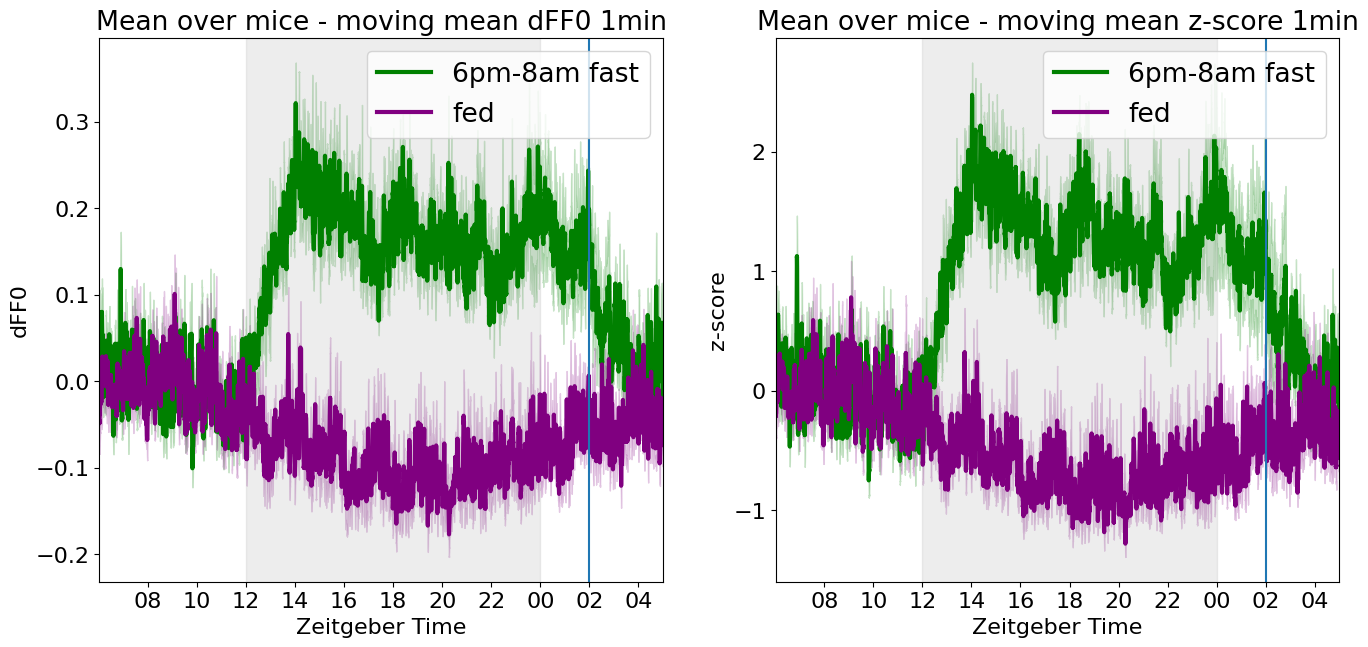

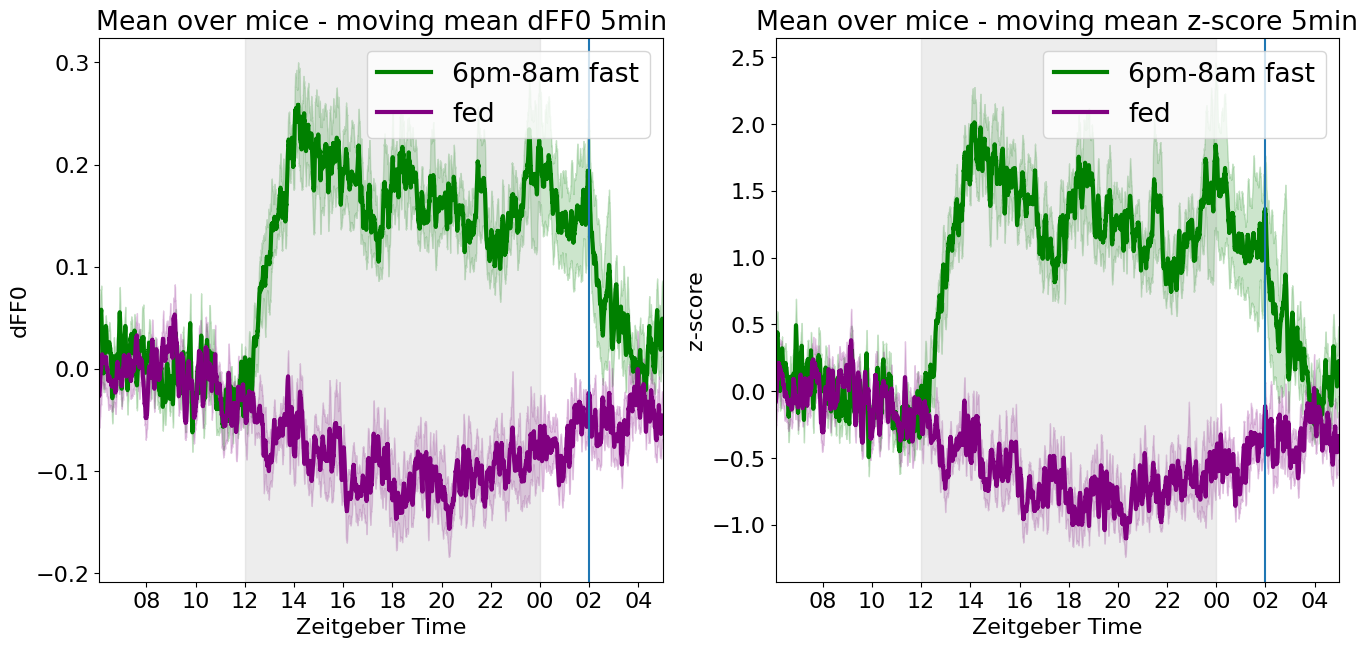

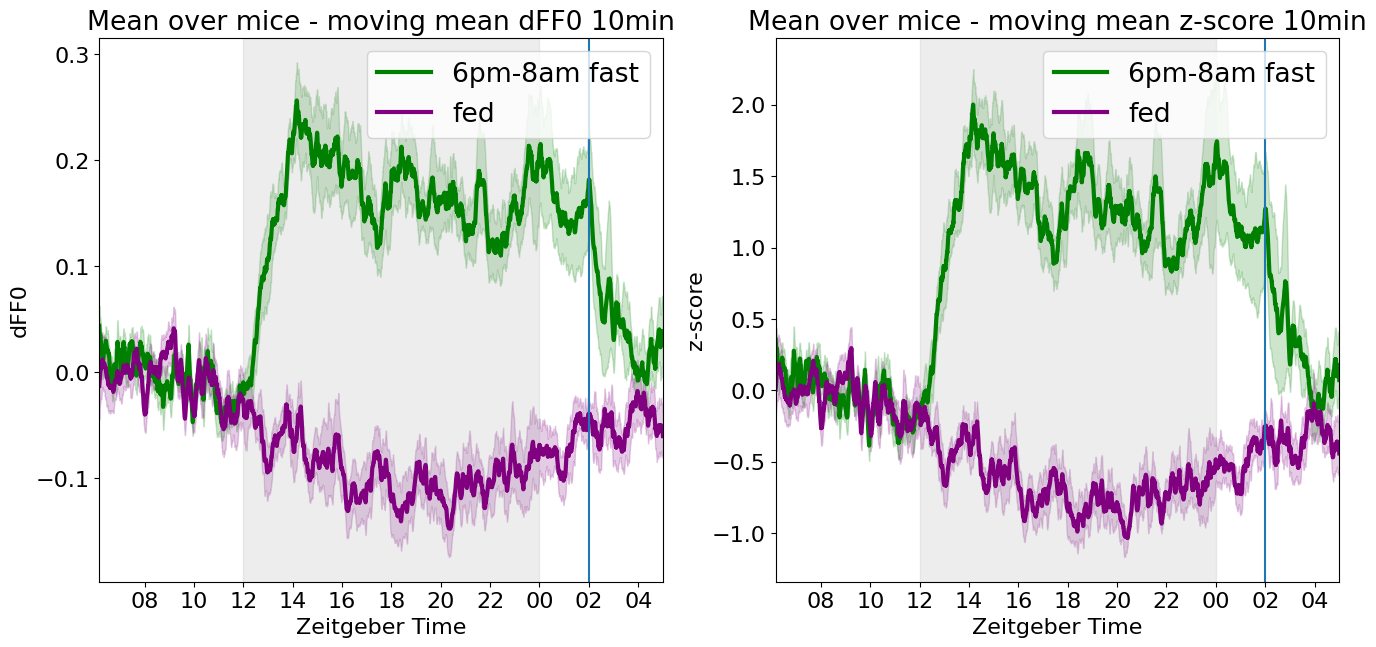

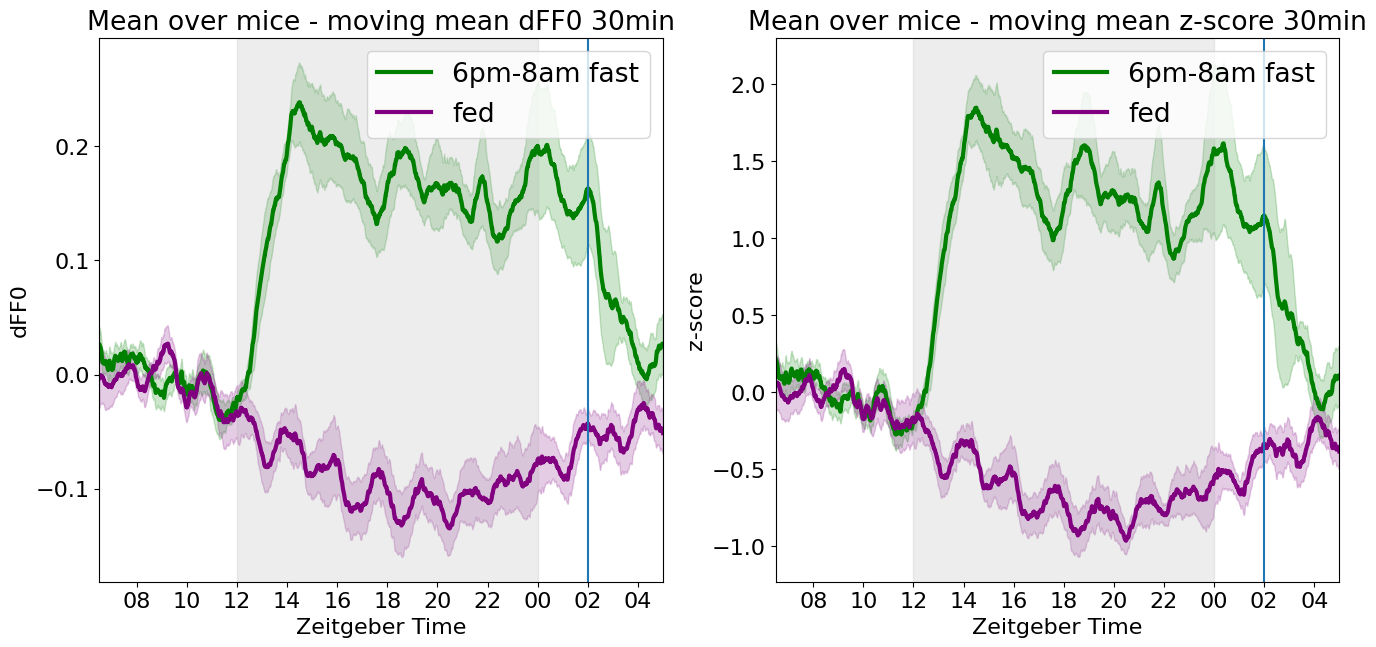

In [8]:
# Now plot different moving mean window values, dF/F0 and z-score in separate plots
for MM in MovingMeanVals:
    fig,((ax1,ax2)) = plt.subplots(1,2,figsize=(16,8))
    axs = [ax1,ax2]
    n=0
    # Loop through dFF0/z-score
    for signal in Mean_Over_Mice[MM].keys():
        # Plot mean trace
        Mean_Over_Mice[MM][signal].plot(color=ColorsToUse, linewidth=3, ax=axs[n])
        axs[n].set(ylabel = signal, xlabel = 'Zeitgeber Time', title = 'Mean over mice - moving mean '+signal+' '+str(MM)+'min')
        axs[n].legend(loc="upper right", fontsize="large")
        # Add SEM
        i=0
        for Stim in ConditionsToPlot:
            axs[n].fill_between(SEM_Over_Mice[MM][signal].index,
                        np.add(Mean_Over_Mice[MM][signal][Stim],SEM_Over_Mice[MM][signal][Stim]).tolist(),
                        np.subtract(Mean_Over_Mice[MM][signal][Stim],SEM_Over_Mice[MM][signal][Stim]).tolist(),
                        color = ColorsToUse[i], alpha=0.2)
            i=i+1
        # Shade in lights-off period (ZT12-ZT0) for each day
        ylim = axs[n].get_ylim()
        for j in list(range(1,len(list(set([i.day for i in list(Mean_Over_Mice[MM][signal].index)]))))):
            axs[n].fill_between([datetime.datetime(1,1,j,12,0,0),datetime.datetime(1,1,j+1,0,0,0)],[ylim[0],ylim[0]],[ylim[1],ylim[1]],
            color='darkgray', alpha=0.2)
        # Plot line to mark other events
        for j in list(EventLabels[EventLabels.notnull().any(axis=1)].index):
            axs[n].plot([j,j],ylim)
        axs[n].set_ylim(ylim)
        # change x tick labels to just show hours (not days)
        date_form = DateFormatter("%H")
        axs[n].xaxis.set_major_formatter(date_form)
        axs[n].set_xticks(axs[n].get_xticks()) # to suppress FixedLocator warning
        axs[n].set_xticklabels(axs[n].get_xticklabels(), rotation=0, ha='center')
        n=n+1

    # save figure as .svg and .png
    figname = ("MM"+str(MM)+"mins_"+ ', '.join(ConditionsToPlot))
    plt.savefig(figname+".svg")
    plt.savefig(figname+".png")

Plot just the time around lights-off.

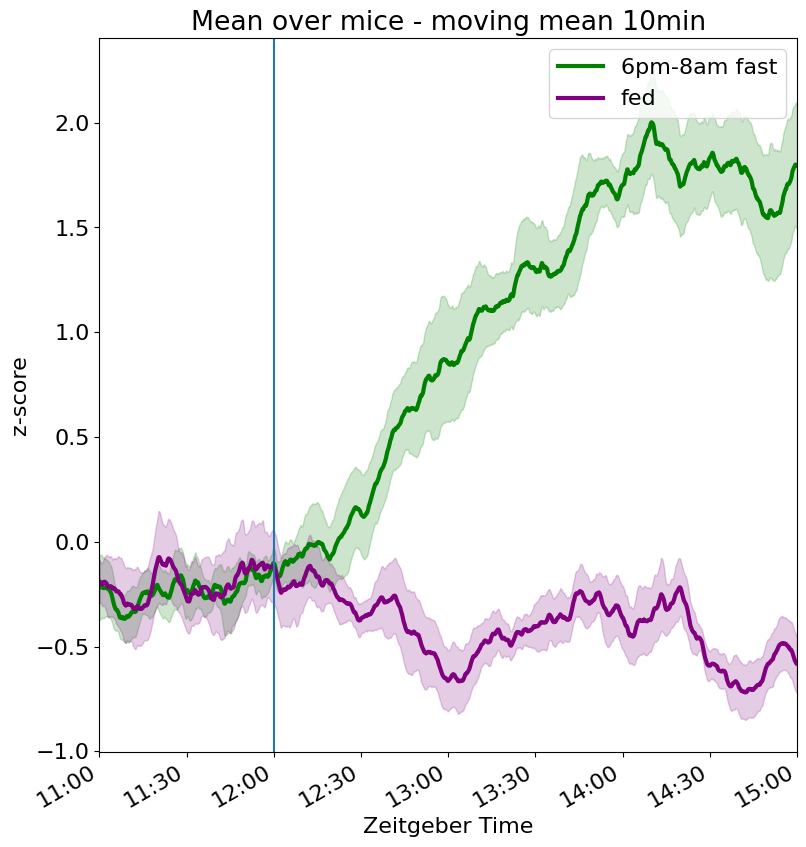

In [10]:
### Set these parameters:
PlotStartDay = 1
PlotStartTime = 11
PlotEndDay = 1
PlotEndTime = 15
EventTime = 12
MM = 10 # the moving mean window size to use (in mins)
signal = 'z-score' # the signal type to plot ('dFF0' or 'z-score)
###

Start = datetime.datetime(1,1,PlotStartDay,PlotStartTime,0)
End = datetime.datetime(1,1,PlotEndDay,PlotEndTime,0)
EventTime = datetime.datetime(1,1,1,EventTime,0)
ax = Mean_Over_Mice[MM][signal][Start:End].plot(color=ColorsToUse, linewidth=3)
ax.set(ylabel = signal, xlabel = 'Zeitgeber Time', title = 'Mean over mice - moving mean '+str(MM)+'min')
#add SEM
i=0
for Stim in ConditionsToPlot:
    plt.fill_between(Mean_Over_Mice[MM][signal][Start:End].index,
    np.add(Mean_Over_Mice[MM][signal][Stim][Start:End],SEM_Over_Mice[MM][signal][Stim][Start:End]).tolist(),
    np.subtract(Mean_Over_Mice[MM][signal][Stim][Start:End],SEM_Over_Mice[MM][signal][Stim][Start:End]).tolist(),
    color = ColorsToUse[i], alpha=0.2)
    i=i+1
ylim = ax.get_ylim()
ax.plot([EventTime,EventTime],ylim)
ax.set_ylim(ylim)
date_form = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(date_form)

plt.savefig('Closeup.svg')
plt.savefig('Closeup.png')

# Poking behavior and pellet retrieval
Plot cumulative pokes and pellets retrieved, and rolling poke rate.

In [11]:
# Represent cumulative pokes and pellets with timepoint every second

my_cols = pd.MultiIndex(levels = [[],[]], codes = [[],[]],
                            names = [u'Cond',u'MouseTrialID'])
AllTrials['Pokes_Pellets']['pokes_cum_ts'] = pd.DataFrame(index = AllTrials['dFF0'].index, columns = my_cols)
AllTrials['Pokes_Pellets']['pellets_cum_ts'] = pd.DataFrame(index = AllTrials['dFF0'].index, columns = my_cols)
# Loop through trials
for Trial in AllTrials['Pokes_Pellets']['pokes_raw'].keys():
    # create dataframe with zeros at every timepoint
    pokes_cum_ts = pd.DataFrame(np.zeros(len(AllTrials['dFF0'].index)), index=AllTrials['dFF0'].index)
    pellets_cum_ts = pd.DataFrame(np.zeros(len(AllTrials['dFF0'].index)), index=AllTrials['dFF0'].index)
    # loop through pokes, fill in times between each poke with cumulative poke number
    prev_poke_time = pokes_cum_ts.index[0]
    for poke_n in range(len(AllTrials['Pokes_Pellets']['pokes_raw'][Trial].index)):
        poke_time = AllTrials['Pokes_Pellets']['pokes_raw'][Trial].index[poke_n]
        pokes_cum_ts.loc[date_range(prev_poke_time,poke_time-datetime.timedelta(seconds=1),1,'seconds')] = poke_n
        prev_poke_time = poke_time
    pokes_cum_ts.loc[date_range(prev_poke_time,pokes_cum_ts.index[-1],1,'seconds')] = poke_n+1
    # same for pellets
    prev_pel_time = pellets_cum_ts.index[0]
    for pel_n in range(len(AllTrials['Pokes_Pellets']['pellets_raw'][Trial].index)):
        pel_time = AllTrials['Pokes_Pellets']['pellets_raw'][Trial].index[pel_n]
        pellets_cum_ts.loc[date_range(prev_pel_time,pel_time-datetime.timedelta(seconds=1),1,'seconds')] = pel_n
        prev_pel_time = pel_time
    pellets_cum_ts.loc[date_range(prev_pel_time,pellets_cum_ts.index[-1],1,'seconds')] = pel_n+1
    # set column = condition for this trial, and MouseTrialID
    pokes_cum_ts.columns = pd.MultiIndex.from_arrays([[AllTrials['Condition'][AllTrials['MouseTrialID'].index(Trial)]],
                                                      [Trial]], names = ['Cond','MouseTrialID'])
    pellets_cum_ts.columns = pokes_cum_ts.columns
    # save to AllTrials
    AllTrials['Pokes_Pellets']['pokes_cum_ts'] = pd.concat([AllTrials['Pokes_Pellets']['pokes_cum_ts'],pokes_cum_ts],axis=1)
    AllTrials['Pokes_Pellets']['pellets_cum_ts'] = pd.concat([AllTrials['Pokes_Pellets']['pellets_cum_ts'],pellets_cum_ts],axis=1)

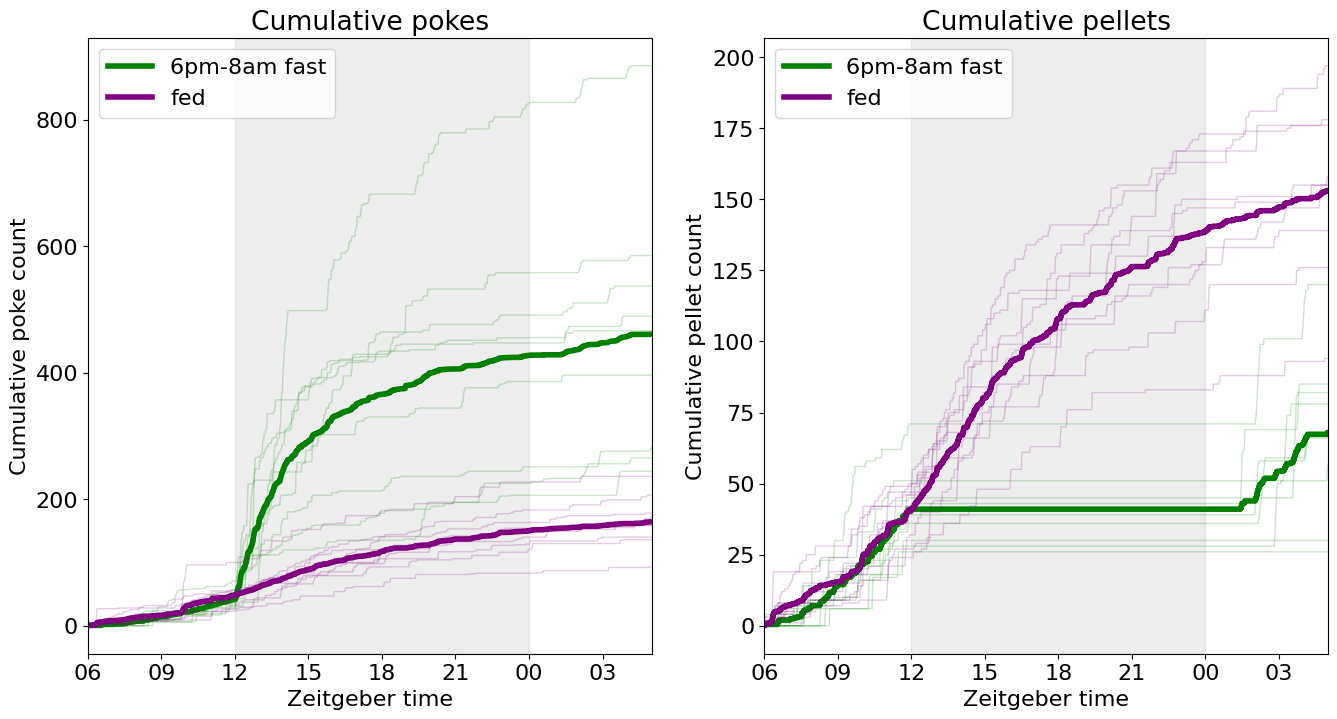

In [12]:
## Two subplots: cumulative poke count, and cumulative pellet count (mean over trials for each condition).

fig,((ax1,ax2)) = plt.subplots(1,2,figsize=(16,8))
n=0
#lines = []
for Cond in ConditionsToPlot:
    ax1.plot(AllTrials['Pokes_Pellets']['pokes_cum_ts'].xs(Cond,level='Cond',axis=1), color=ColorsToUse[n], linewidth=1,alpha=0.2)
    ax1.plot(AllTrials['Pokes_Pellets']['pokes_cum_ts'].xs(Cond,level='Cond',axis=1).mean(axis=1), color=ColorsToUse[n], linewidth=4, label=Cond)
    ax2.plot(AllTrials['Pokes_Pellets']['pellets_cum_ts'].xs(Cond,level='Cond',axis=1), color=ColorsToUse[n], linewidth=1,alpha=0.2)
    ax2.plot(AllTrials['Pokes_Pellets']['pellets_cum_ts'].xs(Cond,level='Cond',axis=1).mean(axis=1), color=ColorsToUse[n], linewidth=4, label=Cond)
    n=n+1

ax1.set(ylabel = 'Cumulative poke count', xlabel = 'Zeitgeber time', title = 'Cumulative pokes')
ax2.set(ylabel = 'Cumulative pellet count', xlabel = 'Zeitgeber time', title = 'Cumulative pellets')

# shade in lights off period
for ax in [ax1,ax2]:
    lowerY = ax.get_ylim()[0]
    upperY = ax.get_ylim()[1]
    for j in list(range(1,len(list(set([i.day for i in AllTrials['Pokes_Pellets']['pokes_cum_ts'].index]))))):
        ax.fill_between([datetime.datetime(1,1,j,12,0,0),datetime.datetime(1,1,j+1,0,0,0)],[lowerY,lowerY],[upperY,upperY], color='darkgray', alpha=0.2)
    ax.set_ylim([lowerY,upperY])
    date_form = DateFormatter("%H")
    ax.xaxis.set_major_formatter(date_form)
    ax.legend()

figname = "Cumulative pokes, pellets"
plt.savefig(figname+'.svg',facecolor="white")
plt.savefig(figname+'.png',facecolor="white")

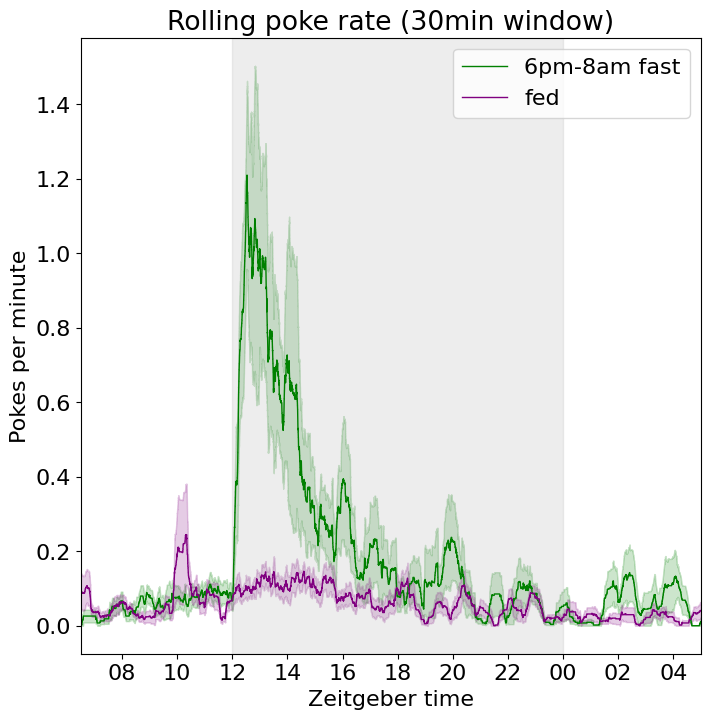

In [13]:
## Rolling poke rate
# take difference of each timepoint of cumulative pokes from the previous one
# then calculate rolling poke rate (10-minute window)
AllTrials['Pokes_Pellets']['poke_rate'] = AllTrials['Pokes_Pellets']['pokes_cum_ts'].diff().rolling(window = 60*30, center=False).mean()*30

# now plot
fig,((ax1)) = plt.subplots(1,1,figsize=(8,8))
n=0
for Cond in ConditionsToPlot:
    ThisCondTrials = AllTrials['Pokes_Pellets']['poke_rate'].xs(Cond,level='Cond',axis=1)
    ME = ThisCondTrials.mean(axis=1)
    ax1.plot(ME, color=ColorsToUse[n], linewidth=1, label=Cond)
    SE = ThisCondTrials.sem(axis=1)
    ax1.fill_between(ThisCondTrials.index, ME.subtract(SE, fill_value=0), ME.add(SE, fill_value=0), color = ColorsToUse[n], alpha=0.2)
    n=n+1

ax1.set_ylabel('Pokes per minute')
ax1.set_xlabel('Zeitgeber time')
ax1.set_title('Rolling poke rate (30min window)')
ax1.legend()
# shade in lights off period
lowerY = ax1.get_ylim()[0]
upperY = ax1.get_ylim()[1]
for j in list(range(1,len(list(set([i.day for i in AllTrials['Pokes_Pellets']['poke_rate'].index]))))):
    ax1.fill_between([datetime.datetime(1,1,j,12,0,0),datetime.datetime(1,1,j+1,0,0,0)],[lowerY,lowerY],[upperY,upperY], color='darkgray', alpha=0.2)
ax1.set_ylim([lowerY,upperY])
ax1.xaxis.set_major_formatter(date_form)

# save figure in svg and png formats
figname = "Rolling poke rate"
plt.savefig(figname+'.svg')
plt.savefig(figname+'.png')


# Poke bout-triggered activity
We want to know how these neurons respond to animals' food-seeking behavior. To look at this, let's align activity to poke bouts (bouts of food-seeking behavior). We will compare activity triggered on the start of poke bouts in different phases (pre-fast, fasting, and refeeding) across conditions.

In [14]:
# Initialize dict
PokeBoutStart_MeanPerTrial = {'PreFast':pd.DataFrame(),'Fast':pd.DataFrame(),'Refeed':pd.DataFrame()}

# Loop through trials
for trial in list(set(AllTrials['Poke_Bout_Aligned_Activity']['Norm_raw_Starts'].columns.get_level_values('MouseTrialID'))):
    # Get activity for all bouts in this trial:
    this_trial_bouts = AllTrials['Poke_Bout_Aligned_Activity']['Norm_raw_Starts'].xs(trial, level='MouseTrialID', axis=1)
    this_trial_cond = AllTrials['Condition'][AllTrials['MouseTrialID'].index(trial)]
    cols = pd.MultiIndex.from_arrays([[this_trial_cond],[trial]])
    # Loop through periods
    for period in list(set(this_trial_bouts.columns.get_level_values('Period'))):
        # Take mean over bouts in this period, add to dataframe
        PokeBoutStart_MeanPerTrial[period] = pd.concat([PokeBoutStart_MeanPerTrial[period],
                                    pd.DataFrame(this_trial_bouts.xs(period, level='Period', axis=1).mean(axis=1), columns = cols)], axis=1)

# Add names to MultiIndex
for period in PokeBoutStart_MeanPerTrial.keys():
    PokeBoutStart_MeanPerTrial[period].columns = PokeBoutStart_MeanPerTrial[period].columns.set_names(['Condition','MouseTrialID'])

Plot heatmap of neural activity, where each row is a poke bout. Separate heatmap for each period; within a heatmap, conditions are separated.

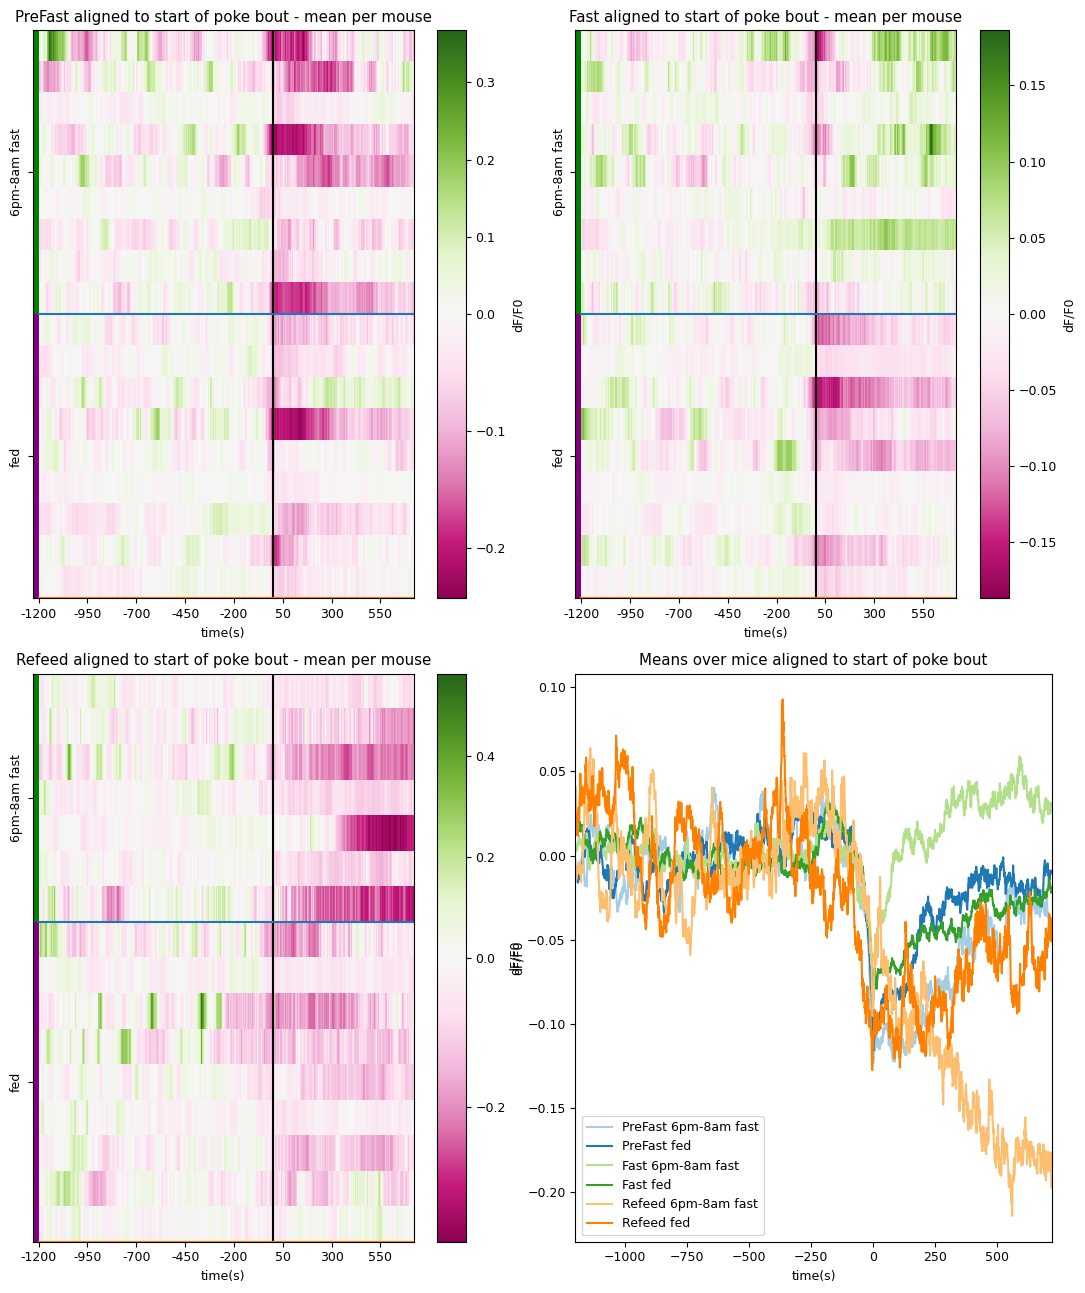

In [18]:
plt.rcParams.update({'font.size': 9})

# Get minimum and maximum activity values, and create colormap
mins = [PokeBoutStart_MeanPerTrial['PreFast'].min().min(),PokeBoutStart_MeanPerTrial['Fast'].min().min(),PokeBoutStart_MeanPerTrial['Refeed'].min().min()]
maxs = [PokeBoutStart_MeanPerTrial['PreFast'].max().max(),PokeBoutStart_MeanPerTrial['Fast'].max().max(),PokeBoutStart_MeanPerTrial['Refeed'].max().max()]
# separate colormap for each period (otherwise one period dominates). to change this, add this line, and remove the divnorm within the loop:
#divnorm=colors.TwoSlopeNorm(vmin=min(mins), vcenter=0., vmax=max(maxs))

# Create figure
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(11,13))

AllAxes = [ax1,ax2,ax3]
Periods = PokeBoutStart_MeanPerTrial.keys()
loopn = -1
# Loop through periods
for P in Periods:
    loopn=loopn+1
    ThisAx = AllAxes[loopn]
    # Loop through conditions
    HeatMapPlot = pd.DataFrame()
    for Cond in ConditionsToPlot:
        ToAdd = pd.DataFrame(PokeBoutStart_MeanPerTrial[P][Cond].transpose())
        ToAdd.index = [Cond]*len(ToAdd)
        HeatMapPlot = pd.concat([HeatMapPlot,ToAdd])
    # Plot heatmap
    divnorm=colors.TwoSlopeNorm(vmin=mins[loopn], vcenter=0., vmax=maxs[loopn])
    im = ThisAx.imshow(HeatMapPlot,aspect='auto',interpolation='none',norm=divnorm,cmap='PiYG')
    ThisAx.set_xticks(range(0,len(PokeBoutStart_MeanPerTrial[P].index),250))
    ThisAx.set_xticklabels([str(i) for i in list(range(PokeBoutStart_MeanPerTrial[P].index[0],PokeBoutStart_MeanPerTrial[P].index[-1],250))])
    ThisAx.set(xlabel="time(s)",
           title=P + " aligned to start of poke bout - mean per mouse")
    ThisAx.plot([0-PokeBoutStart_MeanPerTrial[P].index[0],0-PokeBoutStart_MeanPerTrial[P].index[0]],[-0.5,len(PokeBoutStart_MeanPerTrial[P].columns)-0.5],color='black')
    ThisAx.set_xlim(-30,0.5-PokeBoutStart_MeanPerTrial[P].index[0]+PokeBoutStart_MeanPerTrial[P].index[-1])
    c=-1
    t=-0.5
    ylab = []
    for Cond in ConditionsToPlot:
        c=c+1
        t1 = len(PokeBoutStart_MeanPerTrial[P][Cond].transpose())
        ThisAx.plot([0,len(PokeBoutStart_MeanPerTrial[P][Cond])],[t+t1,t+t1])
        rect = patches.Rectangle((-30,t),30,t1,fc=ColorsToUse[c])
        ThisAx.add_patch(rect)
        ylab.append((t + t+t1)/2)
        t=t+t1
    ThisAx.set_yticks(ylab)
    ThisAx.set_yticklabels(ConditionsToPlot,rotation=90,va="center")
    cbar = plt.colorbar(im,ax=ThisAx)
    cbar.set_label('dF/F0')
fig.tight_layout()


# ax4 - plot mean over mice per condition/phase
BoutMeansOverCondPhase = pd.DataFrame()

for P in Periods:
    for Cond in ConditionsToPlot:
        BoutMeansOverCondPhase[P +' '+ Cond] = np.nanmean(PokeBoutStart_MeanPerTrial[P][Cond],axis=1)
        BoutMeansOverCondPhase.index = PokeBoutStart_MeanPerTrial[P].index

colorlist = ["#a6cee3", "#1f78b4","#b2df8a","#33a02c","#fdbf6f","#ff7f00"]#,color=['purple','plum','green','mediumseagreen','darkorange','tan'])
cpal = sns.color_palette(colorlist)
ax4.set_prop_cycle('color', cpal)

ax4.plot(BoutMeansOverCondPhase)
ax4.set(xlabel="time(s)",
        ylabel = "dF/F0",
        title= "Means over mice aligned to start of poke bout")
ax4.legend(BoutMeansOverCondPhase.columns)

fig.savefig('PokeBout-aligned activity per mouse.png',facecolor="white")
fig.savefig('PokeBout-aligned activity per mouse.svg',facecolor="white")


Combine all poke bout start-triggered traces across all mice, for each period

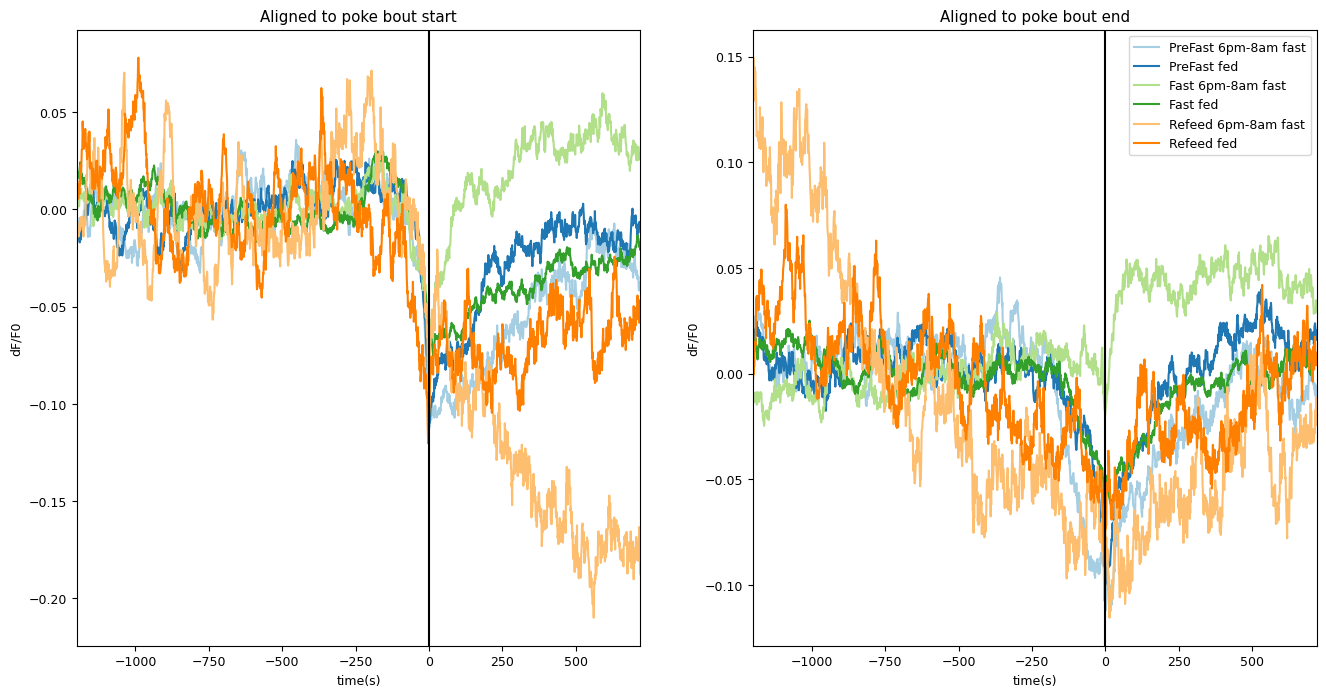

In [19]:
# Plot means for each condition, aligned to bout start and end
fig,((ax1,ax2)) = plt.subplots(1,2,figsize=(16,8))
n=0
leg = []
colorlist = ["#a6cee3", "#1f78b4","#b2df8a","#33a02c","#fdbf6f","#ff7f00"]#,color=['purple','plum','green','mediumseagreen','darkorange','tan'])
cpal = sns.color_palette(colorlist)
#ax4.set_prop_cycle('color', cpal)

for period in PokeBoutStart_MeanPerTrial.keys():
    starts = AllTrials['Poke_Bout_Aligned_Activity']['Norm_raw_Starts'].xs(period, level='Period', axis=1)
    ends = AllTrials['Poke_Bout_Aligned_Activity']['Norm_raw_Ends'].xs(period, level='Period', axis=1)
    for Cond in ConditionsToPlot:
        this_cond_trials = [AllTrials['MouseTrialID'][i] for i in range(len(AllTrials['Condition'])) if AllTrials['Condition'][i]==Cond]
        ax1.plot(starts[[i for i in this_cond_trials if i in starts.columns.get_level_values(0)]].mean(axis=1), color=cpal[n])
        ax2.plot(ends[[i for i in this_cond_trials if i in ends.columns.get_level_values(0)]].mean(axis=1), color=cpal[n])
        # add label
        leg = leg + [period + ' ' + Cond]
        n=n+1

# plot vertical line at t=0
ax1.axvline(x=0, color='black')
ax2.axvline(x=0, color='black')

# set axis properties, add legend
ax1.set(xlabel="time(s)", ylabel="dF/F0", title="Aligned to poke bout start")
ax2.set(xlabel="time(s)", ylabel="dF/F0", title="Aligned to poke bout end")
ax2.legend(leg)

# save figure as png and svg
fig.savefig('Poke bout-aligned activity mean over bouts by period.png',facecolor="white")
fig.savefig('Poke bout-aligned activity mean over bouts by period.svg',facecolor="white")

Same but just for the fast period (e.g. ZT12-ZT2)

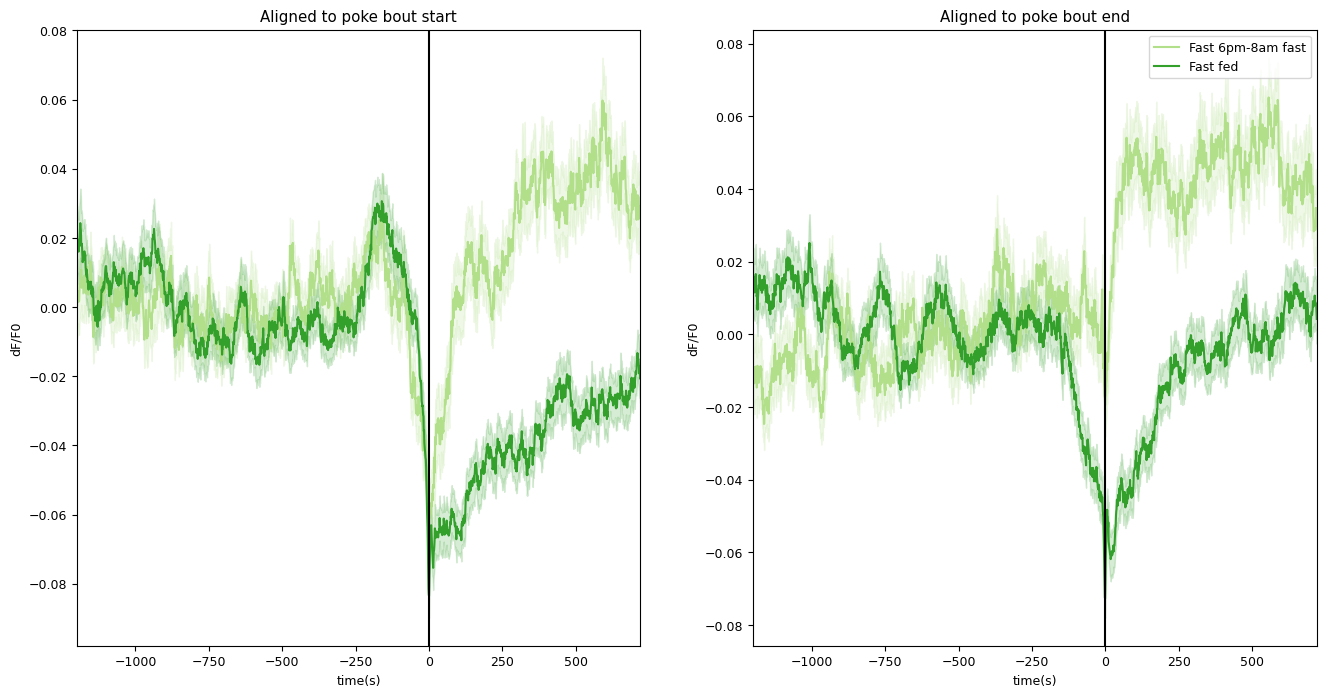

In [25]:
# poke bout - just fast period
fig,((ax1,ax2)) = plt.subplots(1,2,figsize=(16,8))

n=2
leg = []
period = 'Fast'
starts = AllTrials['Poke_Bout_Aligned_Activity']['Norm_raw_Starts'].xs(period, level='Period', axis=1)
ends = AllTrials['Poke_Bout_Aligned_Activity']['Norm_raw_Ends'].xs(period, level='Period', axis=1)
for Cond in ConditionsToPlot:
    this_cond_trials = [AllTrials['MouseTrialID'][i] for i in range(len(AllTrials['Condition'])) if AllTrials['Condition'][i]==Cond]
    ME = starts[this_cond_trials].mean(axis=1)
    ax1.plot(ME, color=cpal[n], label = period + ' ' + Cond)
    SE = starts[this_cond_trials].sem(axis=1)
    ax1.fill_between(starts[this_cond_trials].index.tolist(), ME.subtract(SE, fill_value=0), ME.add(SE, fill_value=0), color = cpal[n], alpha=0.2)
    
    ME = ends[this_cond_trials].mean(axis=1)
    ax2.plot(ME, color=cpal[n], label = period + ' ' + Cond)
    SE = ends[this_cond_trials].sem(axis=1)
    ax2.fill_between(starts[this_cond_trials].index.tolist(), ME.subtract(SE, fill_value=0), ME.add(SE, fill_value=0), color = cpal[n], alpha=0.2)
    n=n+1

# plot vertical line at t=0
ax1.axvline(x=0, color='black')
ax2.axvline(x=0, color='black')

# set axis properties, add legend
ax1.set(xlabel="time(s)", ylabel="dF/F0", title="Aligned to poke bout start")
ax2.set(xlabel="time(s)", ylabel="dF/F0", title="Aligned to poke bout end")
ax2.legend()

# save figure as png and svg
fig.savefig('Poke bout-aligned activity mean over bouts fast only.png',facecolor="white")
fig.savefig('Poke bout-aligned activity mean over bouts fast only.svg',facecolor="white")

To see how the response to poking behavior varies with the length of a poke bout, we will plot activity for every individual poke bout, with the duration of that bout annotated. Let's use a heatmap of activity aligned to all poke bouts from all mice, divided by period and condition.

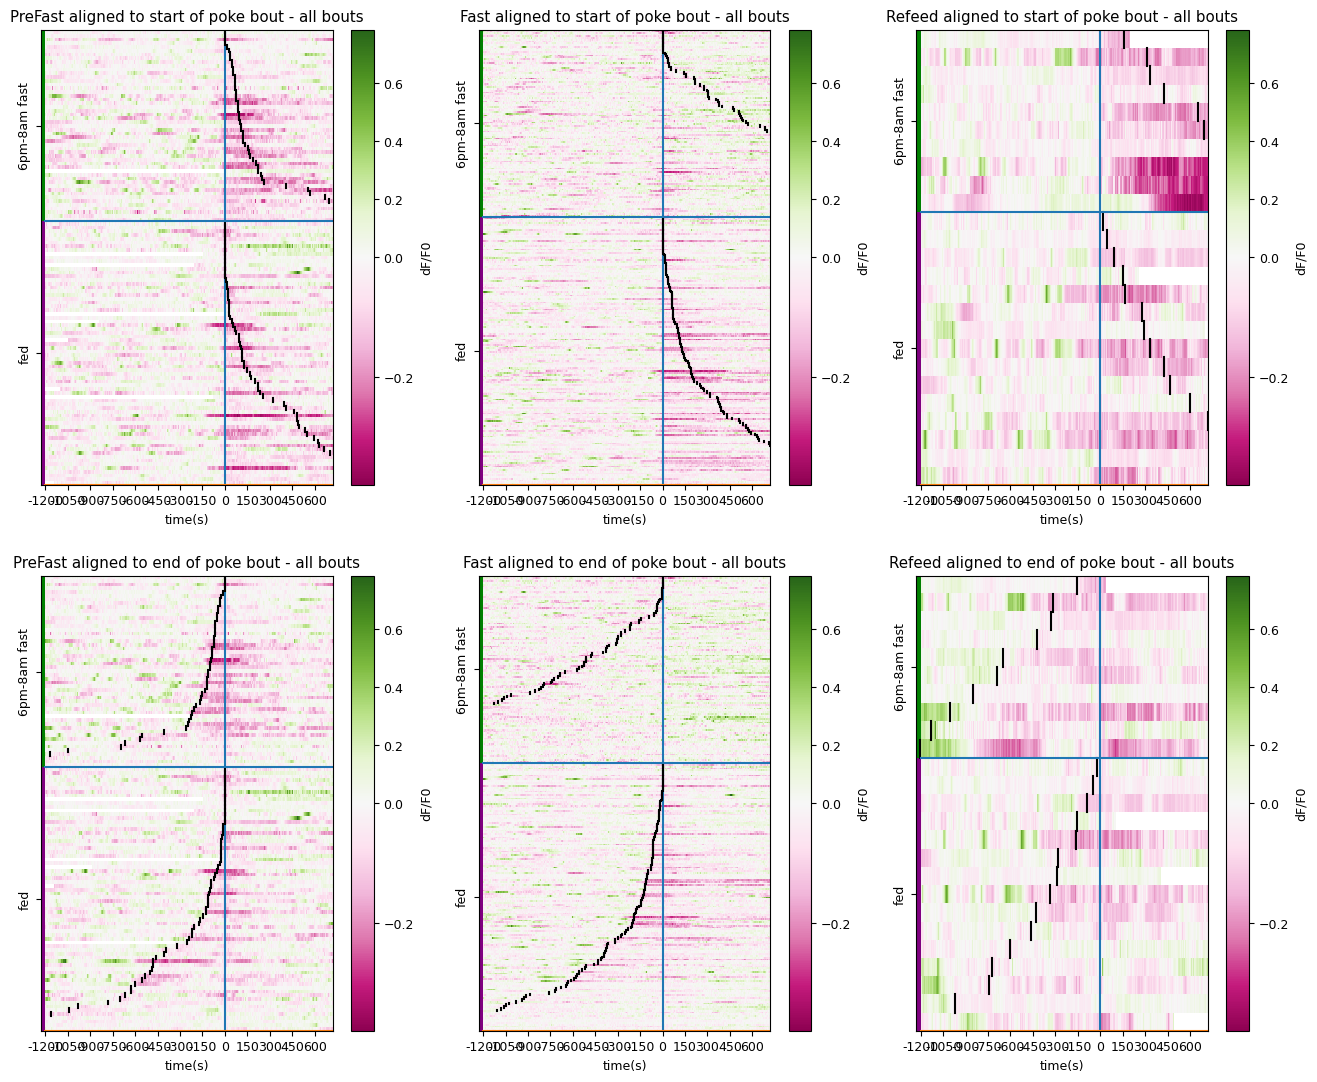

In [27]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(16,13))
FirstAxes = [ax1,ax2,ax3]
SecondAxes = [ax4,ax5,ax6]

# create colormap
divnorm = colors.TwoSlopeNorm(vmin=AllTrials['Poke_Bout_Aligned_Activity']['Norm_raw_Starts'].min().min(), vcenter=0.,
                              vmax=AllTrials['Poke_Bout_Aligned_Activity']['Norm_raw_Starts'].max().max())

# loop through periods, get bouts from this period
n=-1
for period in PokeBoutStart_MeanPerTrial.keys():
    n=n+1
    starts = AllTrials['Poke_Bout_Aligned_Activity']['Norm_raw_Starts'].xs(period, level='Period', axis=1)
    ends = AllTrials['Poke_Bout_Aligned_Activity']['Norm_raw_Ends'].xs(period, level='Period', axis=1)
     # get list of bout durations
    start_bout_durs = [AllTrials['PokeBouts'][list(bout)[0]][AllTrials['PokeBouts'][list(bout)[0]]['BoutStarts']==list(bout)[1]]['BoutDurs'].tolist()[0]
                        for bout in starts.columns]
    # get condition for each mouse
    start_bout_conds = [AllTrials['Condition'][AllTrials['MouseTrialID'].index(i)] for i in list(starts.columns.get_level_values('MouseTrialID'))]
    old_col = starts.columns.to_frame()
    old_col.insert(0, 'Cond', np.array(start_bout_conds))
    old_col.insert(1, 'BoutDurs', np.array(start_bout_durs))
    starts.columns = pd.MultiIndex.from_frame(old_col)
    end_bout_durs = [AllTrials['PokeBouts'][list(bout)[0]][AllTrials['PokeBouts'][list(bout)[0]]['BoutEnds']==list(bout)[1]]['BoutDurs'].tolist()[0]
                        for bout in ends.columns]
    end_bout_conds = [AllTrials['Condition'][AllTrials['MouseTrialID'].index(i)] for i in list(ends.columns.get_level_values('MouseTrialID'))]
    old_col = ends.columns.to_frame()
    old_col.insert(0, 'Cond', np.array(end_bout_conds))
    old_col.insert(1, 'BoutDurs', np.array(end_bout_durs))
    ends.columns = pd.MultiIndex.from_frame(old_col)
    starts = starts.sort_index(level=['Cond','BoutDurs'], axis=1)
    ends = ends.sort_index(level=['Cond','BoutDurs'],axis=1)
    
    # plot heatmap for poke bout starts
    ThisAx = FirstAxes[n]
    im = ThisAx.imshow(starts.transpose(),aspect='auto',interpolation='none',norm=divnorm,cmap='PiYG')
    ThisAx.set_xticks(range(0,len(starts.index),150))
    ThisAx.set_xticklabels([str(i) for i in list(range(starts.index[0],starts.index[-1],150))])
    ThisAx.set(xlabel="time(s)",
           title=period + " aligned to start of poke bout - all bouts")
    ThisAx.axvline(x=0-starts.index[0])
    ThisAx.set_xlim(-30,0.5-starts.index[0]+starts.index[-1])
    
    #tick at end of poke bout
    boutn=-1
    for bd in starts.columns.get_level_values('BoutDurs'):
        boutn = boutn+1
        ThisAx.plot([0-starts.index[0]+bd,0-starts.index[0]+bd],[boutn-0.5,boutn+0.5],color='black')

    # same for poke bout ends
    ThatAx = SecondAxes[n]
    im1 = ThatAx.imshow(ends.transpose(),aspect='auto',interpolation='none',norm=divnorm,cmap='PiYG')
    ThatAx.set_xticks(range(0,len(ends.index),150))
    ThatAx.set_xticklabels([str(i) for i in list(range(ends.index[0],ends.index[-1],150))])
    ThatAx.set(xlabel="time(s)",
           title=period + " aligned to end of poke bout - all bouts")
    ThatAx.axvline(x=0-ends.index[0])
    ThatAx.set_xlim(-30,0.5-ends.index[0]+ends.index[-1])

    #tick at start of poke bout
    boutn=-1
    for bd in ends.columns.get_level_values('BoutDurs'):
        boutn = boutn+1
        ThatAx.plot([0-starts.index[0]-bd,0-starts.index[0]-bd],[boutn-0.5,boutn+0.5],color='black')

    #add y-axis label for conditions
    c=-1
    ts=-0.5
    te=-0.5
    ylab_s = []
    ylab_e = []
    for Cond in ConditionsToPlot:
        c=c+1
        t1s = len(starts.loc[:,Cond].columns)
        t1e = len(ends.loc[:,Cond].columns)

        ThisAx.plot([0,len(starts.loc[:,Cond])],[ts+t1s,ts+t1s])
        ThatAx.plot([0,len(starts.loc[:,Cond])],[te+t1e,te+t1e])
        rect = patches.Rectangle((-30,ts),30,t1s,fc=ColorsToUse[c])
        ThisAx.add_patch(rect)
        rect1 = patches.Rectangle((-30,te),30,t1e,fc=ColorsToUse[c])
        ThatAx.add_patch(rect1)
        ylab_s.append((ts + ts+t1s)/2)
        ylab_e.append((te + te+t1e)/2)
        ts=ts+t1s
        te=te+t1e
    ThisAx.set_yticks(ylab_s)
    ThisAx.set_yticklabels(ConditionsToPlot,rotation=90,va="center")
    ThatAx.set_yticks(ylab_e)
    ThatAx.set_yticklabels(ConditionsToPlot,rotation=90,va="center")
    cbar = plt.colorbar(im,ax=ThisAx)
    cbar.set_label('dF/F0')
    cbar1 = plt.colorbar(im1,ax=ThatAx)
    cbar1.set_label('dF/F0')

# save figure as png and svg
fig.savefig('Poke bout-aligned activity all bouts.png',facecolor="white")
fig.savefig('Poke bout-aligned activity all bouts.svg',facecolor="white")

# Poke-triggered activity
Rather than looking at poke bouts, we can also align activity to individual pokes. We will compare activity triggered on individual pokes in different phases across conditions.

In [28]:
# Get trial averages of dF/F0 aligned to poke for each period of trial
PokeTriggered_MeanPerTrial = {'PreFast':pd.DataFrame(),'Fast':pd.DataFrame(),'Refeed':pd.DataFrame()}
# now loop through trials
for period in PokeTriggered_MeanPerTrial.keys():
    for trial in list(set(AllTrials['Pokes_Pellets']['poke_activity']['dFF0_'+period].columns.get_level_values(0))):
        # define columns (condition and trial ID)
        cols = pd.MultiIndex.from_arrays([[AllTrials['Condition'][AllTrials['MouseTrialID'].index(trial)]],[trial]])
        # take mean poke bout start-triggered activity for this trial for each period:
        PokeTriggered_MeanPerTrial[period] = pd.concat([PokeTriggered_MeanPerTrial[period],
                    pd.DataFrame(AllTrials['Pokes_Pellets']['poke_activity']['dFF0_'+period][trial].mean(axis=1),columns = cols)],axis=1)
    # Add names to MultiIndex
    PokeBoutStart_MeanPerTrial[period].columns = PokeBoutStart_MeanPerTrial[period].columns.set_names(['Condition','MouseTrialID'])

Plot heatmap of neural activity aligned to pokes, where each row is the average over pokes for a single trial. Separate heatmap for each period of the trial; within a heatmap, conditions are separated.

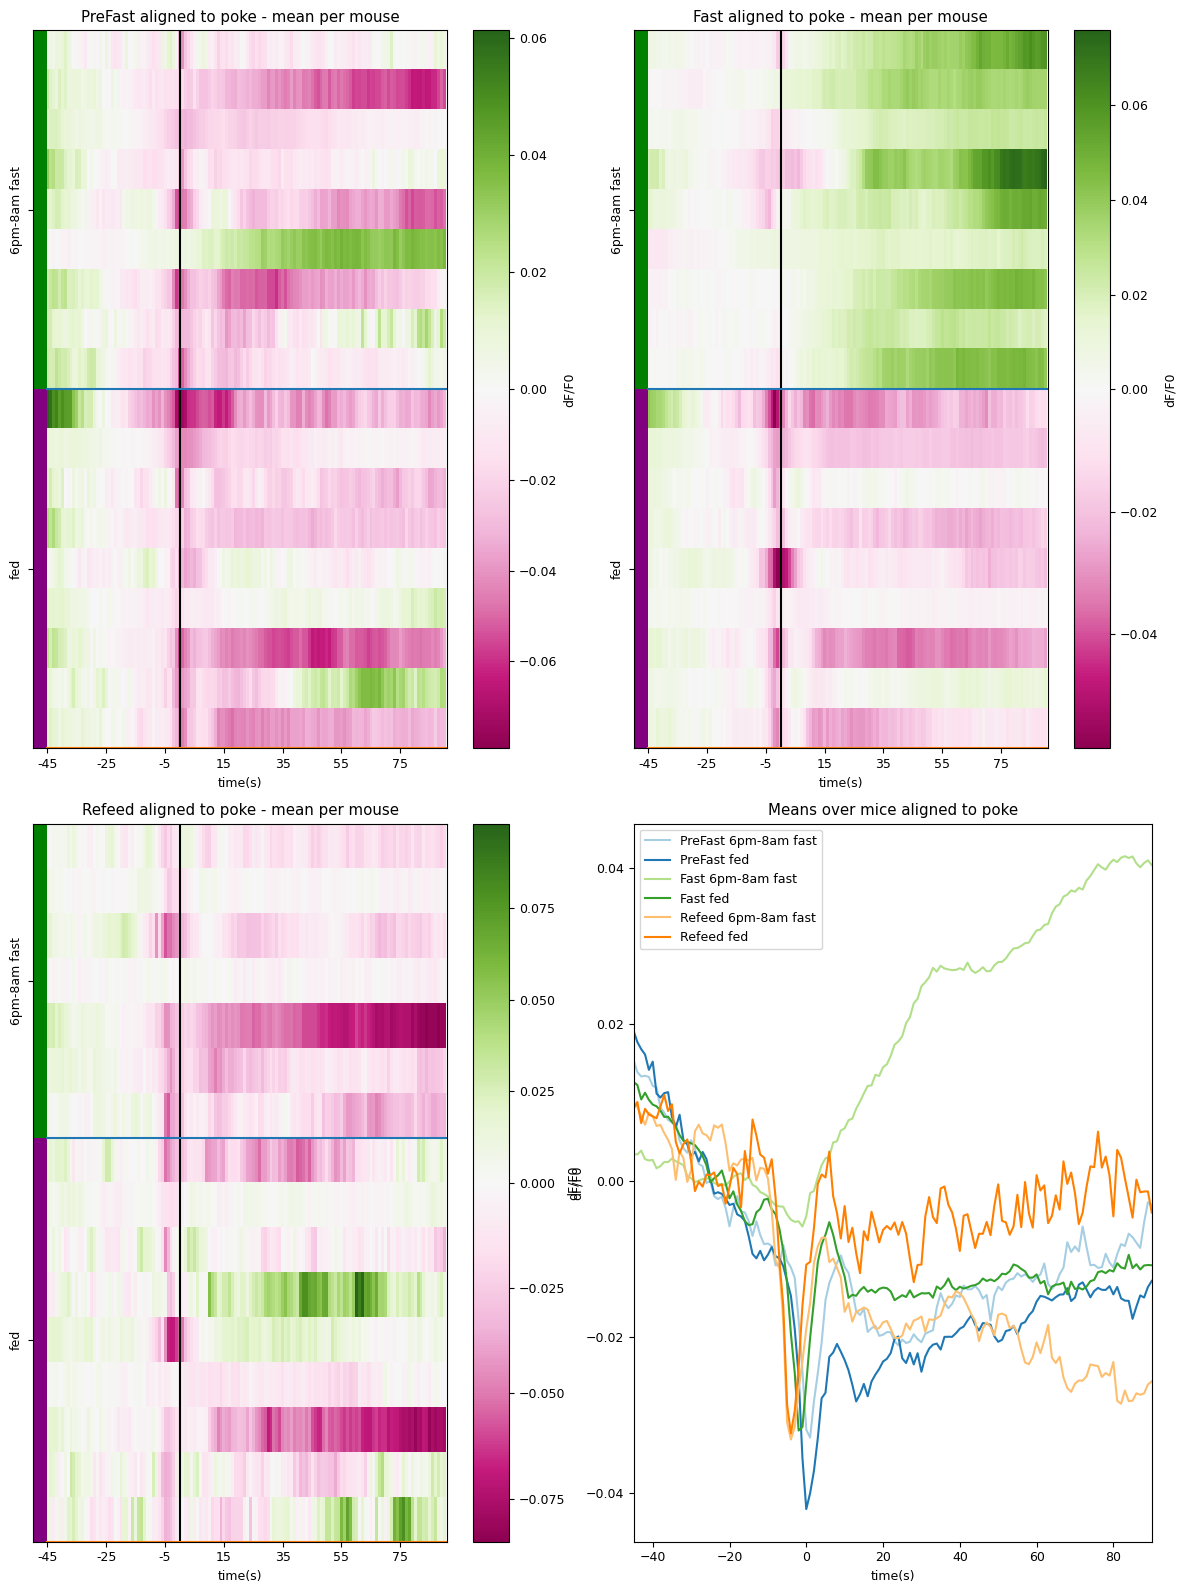

In [29]:
# Get minimum and maximum values for colormap
mins = [PokeTriggered_MeanPerTrial[x].min().min() for x in PokeTriggered_MeanPerTrial.keys()]
maxs = [PokeTriggered_MeanPerTrial[x].max().max() for x in PokeTriggered_MeanPerTrial.keys()]

# Initialize figure
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,16))

AllAxes = [ax1,ax2,ax3]
Periods = PokeTriggered_MeanPerTrial.keys()
loopn = -1
# Loop through periods
for P in Periods:
    loopn = loopn+1
    ThisAx = AllAxes[loopn]
    # Loop through conditions, create dataframe to be plotted by concatenating conditions
    HeatMapPlot = pd.DataFrame()
    for Cond in ConditionsToPlot:
        ToAdd = pd.DataFrame(PokeTriggered_MeanPerTrial[P][Cond].transpose())
        ToAdd.index = [Cond]*len(ToAdd)
        HeatMapPlot = pd.concat([HeatMapPlot,ToAdd])
    # Plot heatmap
    divnorm = colors.TwoSlopeNorm(vmin=mins[loopn], vcenter=0., vmax=maxs[loopn])
    im = ThisAx.imshow(HeatMapPlot,aspect='auto',interpolation='none',norm=divnorm,cmap='PiYG')
    # set axis properties
    ThisAx.set_xticks(range(0,len(PokeTriggered_MeanPerTrial[P].index),20))
    ThisAx.set_xticklabels([str(i) for i in list(range(PokeTriggered_MeanPerTrial[P].index[0],PokeTriggered_MeanPerTrial[P].index[-1],20))])
    ThisAx.set(xlabel="time(s)",
           title=P + " aligned to poke - mean per mouse")
    # plot vertical line at poke time (t=0)
    ThisAx.axvline(x=0-PokeTriggered_MeanPerTrial[P].index[0], color='black')
    # label conditions using rectangle
    c=0
    t=-0.5
    ylab = []
    for Cond in ConditionsToPlot:
        t1 = len(PokeTriggered_MeanPerTrial[P][Cond].transpose())
        ThisAx.plot([0,len(PokeTriggered_MeanPerTrial[P][Cond])],[t+t1,t+t1])
        rect = patches.Rectangle((-5,t),5,t1,fc=ColorsToUse[c])
        ThisAx.add_patch(rect)
        ylab.append((t + t+t1)/2)
        c=c+1
        t=t+t1
    ThisAx.set_yticks(ylab)
    ThisAx.set_yticklabels(ConditionsToPlot,rotation=90,va="center")
    # add colorbar
    cbar = plt.colorbar(im,ax=ThisAx)
    cbar.set_label('dF/F0')
fig.tight_layout()


# On final axes, plot mean over mice per condition/phase
PokeMeansOverCondPhase = pd.DataFrame()

for P in Periods:
    for Cond in ConditionsToPlot:
        PokeMeansOverCondPhase[P +' '+ Cond] = np.nanmean(PokeTriggered_MeanPerTrial[P][Cond],axis=1)
        PokeMeansOverCondPhase.index = PokeTriggered_MeanPerTrial[P].index

ax4.set_prop_cycle('color', cpal)
ax4.plot(PokeMeansOverCondPhase)#,color=['purple','plum','green','mediumseagreen','darkorange','tan'])
ax4.set(xlabel="time(s)",
        ylabel = "dF/F0",
        title= "Means over mice aligned to poke")
ax4.legend(PokeMeansOverCondPhase.columns)

# Save figure in png and svg formats
fig.savefig('Poke-aligned activity per mouse.png',facecolor="white")
fig.savefig('Poke-aligned activity per mouse.svg',facecolor="white")

Now plot average poke-triggered activity over all pokes from all mice.

Because pokes are often grouped into bouts, pokes may be preceded by other pokes - in other words, the "baseline" activity during the pre-poke period (45 seconds) may be contaminated by activity related to other pokes. To avoid this, let's also plot activity triggered to "lone pokes" - i.e. pokes that have no other pokes within the pre-poke period.

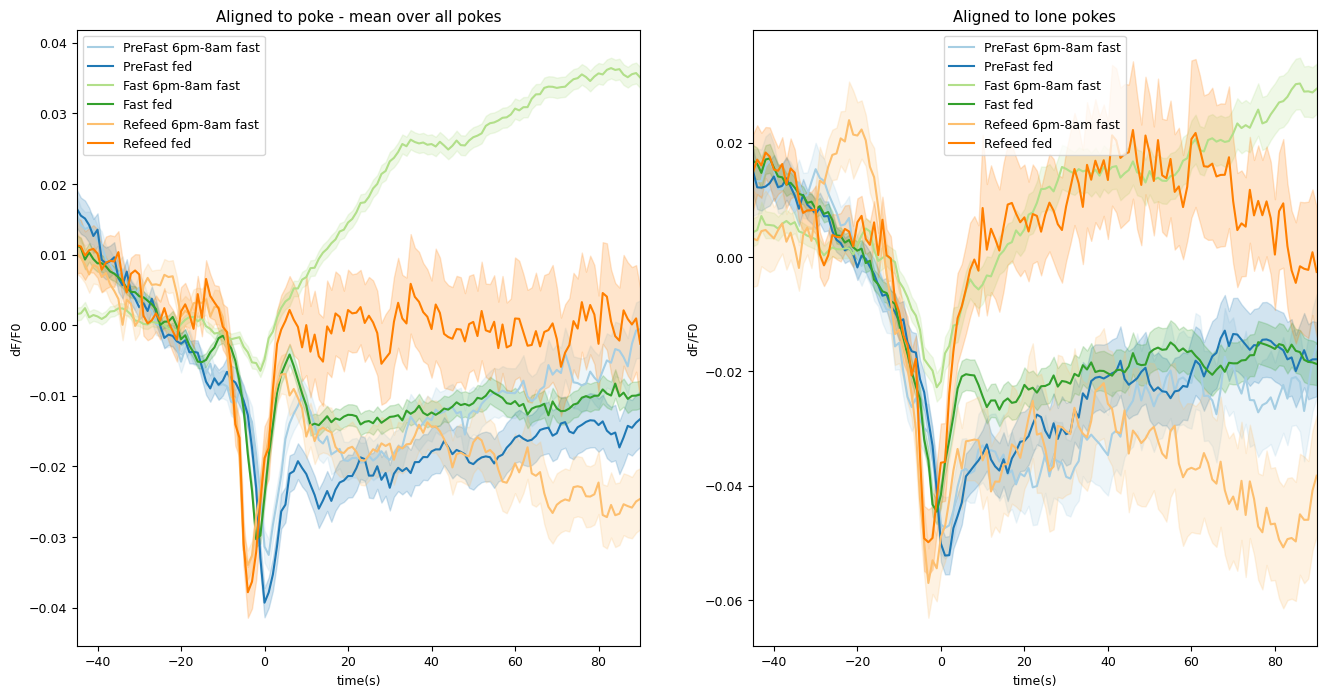

In [30]:
# Plot means for each condition
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
n=0
leg = []
leg_handles = []
my_cols = pd.MultiIndex(levels = [[],[],[],[]], codes = [[],[],[],[]],
                            names = [u'Condition',u'Period',u'MouseTrialID',u'PokeTime'])
Lone_Pokes = pd.DataFrame(columns=my_cols)
for Period in Periods:
    for Cond in ConditionsToPlot:
        # get poke-aligned traces for all pokes in this period corresponding to this condition
        this_cond_trials = [AllTrials['MouseTrialID'][ind] for ind,x in enumerate(AllTrials['Condition']) if x == Cond]
        This_Stim_Trials = AllTrials['Pokes_Pellets']['poke_activity']['dFF0_'+Period][[i for i in 
                                this_cond_trials if i in AllTrials['Pokes_Pellets']['poke_activity']['dFF0_'+Period].columns.get_level_values(0)]]
        # calculate mean and SEM over all pokes in this period/condition
        MN = This_Stim_Trials.mean(axis=1)
        SE = This_Stim_Trials.sem(axis=1)
        # plot mean
        leg_ha = ax1.plot(MN,color=cpal[n], label=Period + ' ' + Cond)
        leg_handles = leg_ha.append(leg_ha)
        # plot SEM
        ax1.fill_between(list(MN.index), MN.subtract(SE, fill_value=0).tolist(), MN.add(SE, fill_value=0).tolist(), color = cpal[n], alpha=0.2)

        # now get the "lone pokes" - loop through trials
        Lone_Pokes_cond = pd.DataFrame(columns=my_cols)
        for trial in list(set(This_Stim_Trials.columns.get_level_values(0))):
            Poke_Times = list(This_Stim_Trials[trial].columns)
            # take the poke times where the preceding poke is >45 seconds before
            Lone_Poke_Times = [v for i,v in enumerate(Poke_Times) if v - Poke_Times[i-1] > datetime.timedelta(seconds=45)]
            # add the first poke
            if len(Poke_Times)>0:
                Lone_Poke_Times = [Poke_Times[0]] + Lone_Poke_Times
            Lone_Pokes_cond = pd.concat([Lone_Pokes_cond,This_Stim_Trials.loc[:,(trial,Lone_Poke_Times)]],axis=1)
        # add condition to columns, and add lone pokes from this condition to dataframe
        old_col = Lone_Pokes_cond.columns.to_frame()
        old_col.insert(0, 'Cond', [Cond]*len(Lone_Pokes_cond.columns))
        old_col.insert(1,'Period', [Period]*len(Lone_Pokes_cond.columns))
        old_col.columns = ['Condition','Period','MouseTrialID','PokeTime']
        Lone_Pokes_cond.columns = pd.MultiIndex.from_frame(old_col)
        Lone_Pokes = pd.concat([Lone_Pokes,Lone_Pokes_cond], axis=1)
        # take mean and SEM over lone poke-aligned traces, and plot
        MN = Lone_Pokes_cond.mean(axis=1)
        SE = Lone_Pokes_cond.sem(axis=1)
        leg_ha = ax2.plot(MN,color=cpal[n], label=Period + ' ' + Cond)
        leg_handles = leg_ha.append(leg_ha)
        ax2.fill_between(list(MN.index), MN.subtract(SE, fill_value=0).tolist(), MN.add(SE, fill_value=0).tolist(), color = cpal[n], alpha=0.2)
        n=n+1
Lone_Pokes.sort_index(axis=1,level='Condition',inplace=True)

# add axis titles and legends
ax1.set(xlabel="time(s)", ylabel="dF/F0", title="Aligned to poke - mean over all pokes")
ax1.legend(handles=leg_handles)
ax2.set(xlabel="time(s)", ylabel="dF/F0", title="Aligned to lone pokes")
ax2.legend(handles=leg_handles)

# Save figures in png and svg formats
fig.savefig('Poke-aligned activity mean over pokes by period.png',facecolor="white")
fig.savefig('Poke-aligned activity mean over pokes by period.svg',facecolor="white")

Same but just for the fast period (ZT12-ZT2)

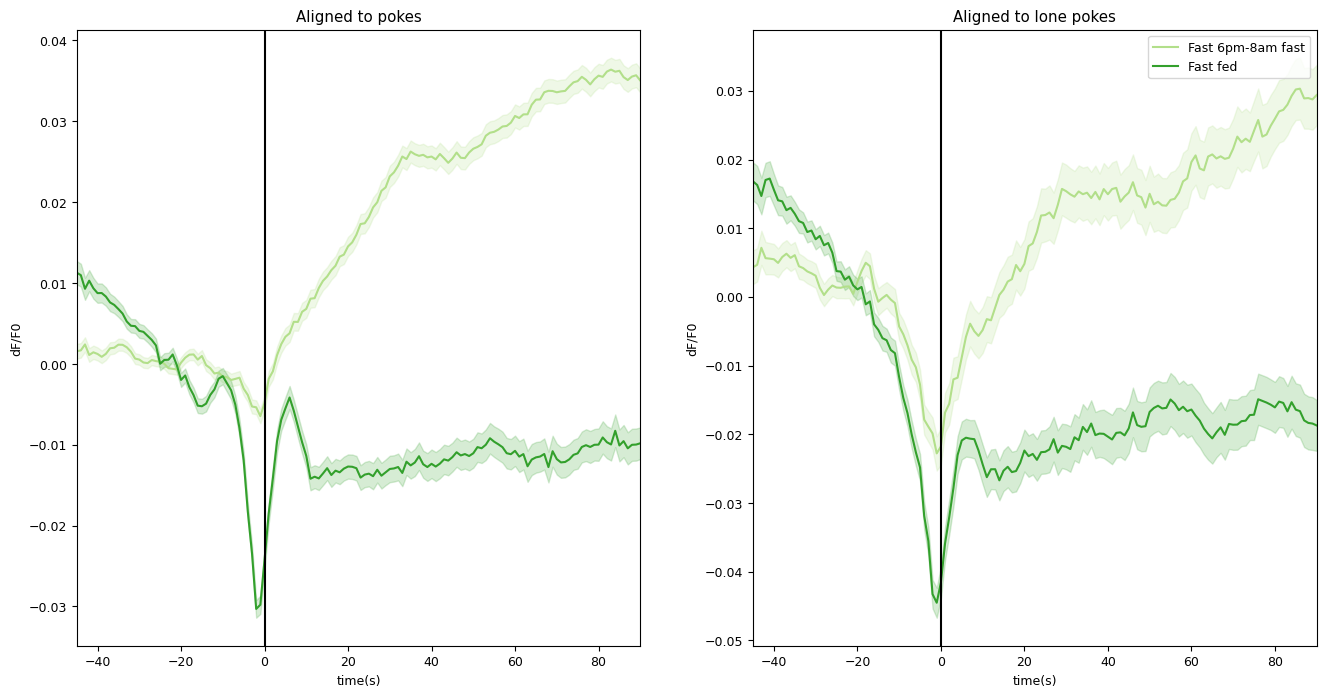

In [31]:
# pokes - just fast period
fig,((ax1,ax2)) = plt.subplots(1,2,figsize=(16,8))

n=2
leg = []
Period = 'Fast'
for Cond in ConditionsToPlot:
     # get poke-aligned traces for all pokes in this period corresponding to this condition
    This_Stim_Trials = AllTrials['Pokes_Pellets']['poke_activity']['dFF0_'+Period][[AllTrials['MouseTrialID'][ind] for ind,x
                                                                                    in enumerate(AllTrials['Condition']) if x == Cond]]
    # calculate mean and SEM over all pokes in this period/condition
    MN = This_Stim_Trials.mean(axis=1)
    SE = This_Stim_Trials.sem(axis=1)
    # plot mean
    leg_ha = ax1.plot(MN,color=cpal[n], label=Period + ' ' + Cond)
    leg_handles = leg_ha.append(leg_ha)
    # plot SEM
    ax1.fill_between(list(MN.index), MN.subtract(SE, fill_value=0).tolist(), MN.add(SE, fill_value=0).tolist(), color = cpal[n], alpha=0.2)

    # take mean and SEM over lone poke-aligned traces, and plot
    MN = Lone_Pokes[Cond,Period].mean(axis=1)
    SE = Lone_Pokes[Cond,Period].sem(axis=1)
    leg_ha = ax2.plot(MN,color=cpal[n], label=Period + ' ' + Cond)
    leg_handles = leg_ha.append(leg_ha)
    ax2.fill_between(list(MN.index), MN.subtract(SE, fill_value=0).tolist(), MN.add(SE, fill_value=0).tolist(), color = cpal[n], alpha=0.2)
    n=n+1

# plot vertical line at t=0
ax1.axvline(x=0, color='black')
ax2.axvline(x=0, color='black')

# set axis properties, add legend
ax1.set(xlabel="time(s)", ylabel="dF/F0", title="Aligned to pokes")
ax2.set(xlabel="time(s)", ylabel="dF/F0", title="Aligned to lone pokes")
ax2.legend(handles=leg_handles)

# save figure as png and svg
fig.savefig('Poke-aligned activity mean over pokes fast only.png',facecolor="white")
fig.savefig('Poke-aligned activity mean over bouts fast only.svg',facecolor="white")

To see how robust these poke responses are, let's look at every poke. We will plot heatmaps of activity around every poke from every mouse, divided by condition and period.

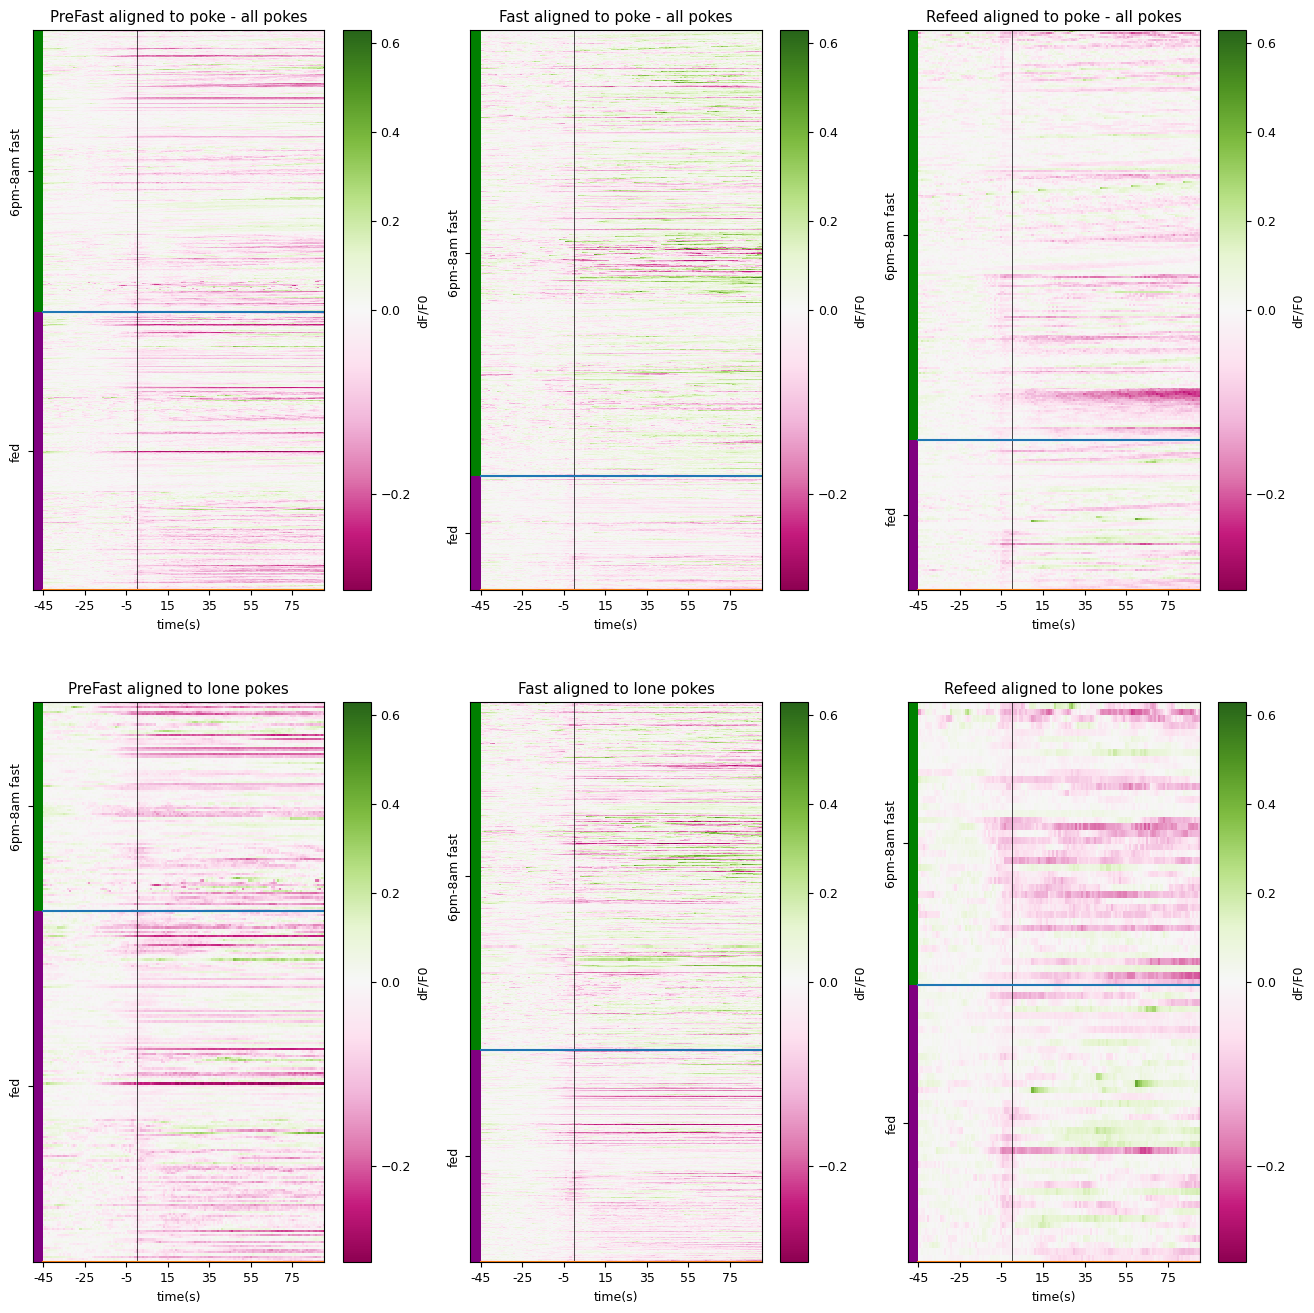

In [32]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(16,16))
AllAxes = [ax1,ax2,ax3]
ThoseAxes = [ax4,ax5,ax6]

# create heatmap
divnorm = colors.TwoSlopeNorm(vmin=AllTrials['Pokes_Pellets']['poke_activity']['dFF0'].min().min(), vcenter=0.,
                              vmax=AllTrials['Pokes_Pellets']['poke_activity']['dFF0'].max().max())

# loop through periods
loopn=-1
for Period in Periods:
    loopn=loopn+1
    ThisAx = AllAxes[loopn]
    ThatAx = ThoseAxes[loopn]
    # plot heatmap
    # order bouts according to condition and then duration
    HeatMapPlot = pd.DataFrame()
    HeatMapPlot2 = pd.DataFrame()
    Cond_Lens = []
    for Cond in ConditionsToPlot:
        this_cond_trials = [AllTrials['MouseTrialID'][ind] for ind,x in enumerate(AllTrials['Condition']) if x == Cond]
        ToAdd = AllTrials['Pokes_Pellets']['poke_activity']['dFF0_'+Period][[i for i in this_cond_trials if i in
                                            AllTrials['Pokes_Pellets']['poke_activity']['dFF0_'+Period].columns.get_level_values(0)]].transpose()
        ToAdd.index = [Cond]*len(ToAdd)
        HeatMapPlot = pd.concat([HeatMapPlot,ToAdd])
        Cond_Lens.append(len(ToAdd))

        ToAdd2 = pd.DataFrame(Lone_Pokes[Cond,Period].transpose())
        ToAdd2.index = [Cond]*len(ToAdd2)
        HeatMapPlot2 = pd.concat([HeatMapPlot2,ToAdd2])

    # plot heatmap
    im = ThisAx.imshow(HeatMapPlot,aspect='auto',interpolation='none',norm=divnorm,cmap='PiYG')
    ThisAx.set_xticks(range(0,len(HeatMapPlot.columns),20))
    ThisAx.set_xticklabels([str(i) for i in list(range(HeatMapPlot.columns[0],HeatMapPlot.columns[-1],20))])
    ThisAx.set(xlabel="time(s)",
           title=Period + " aligned to poke - all pokes")
    ThisAx.plot([0-HeatMapPlot.columns[0],0-HeatMapPlot.columns[0]],[-0.5,len(HeatMapPlot.index)-0.5],color='black',linewidth=0.5)
    ThisAx.set_xlim(-5,0.5-HeatMapPlot.columns[0]+HeatMapPlot.columns[-1])

    im = ThatAx.imshow(HeatMapPlot2,aspect='auto',interpolation='none',norm=divnorm,cmap='PiYG')
    ThatAx.set_xticks(range(0,len(HeatMapPlot2.columns),20))
    ThatAx.set_xticklabels([str(i) for i in list(range(HeatMapPlot2.columns[0],HeatMapPlot2.columns[-1],20))])
    ThatAx.plot([0-HeatMapPlot2.columns[0],0-HeatMapPlot2.columns[0]],[-0.5,len(HeatMapPlot2.index)-0.5],color='black',linewidth=0.5)
    ThatAx.set_xlim(-5,0.5-HeatMapPlot2.columns[0]+HeatMapPlot2.columns[-1])
    ThatAx.set(xlabel="time(s)",
           title=Period + " aligned to lone pokes")

    # add y-axis label for conditions
    c=-1
    ts=-0.5
    ts2=-0.5
    ylab_s = []
    ylab_s2 = []
    for Cond in ConditionsToPlot:
        c=c+1
        t1s = Cond_Lens[c]
        ThisAx.plot([0,len(HeatMapPlot.transpose())],[ts+t1s,ts+t1s])
        rect = patches.Rectangle((-5,ts),5,t1s,fc=ColorsToUse[c])
        ThisAx.add_patch(rect)
        ylab_s.append((ts + ts+t1s)/2)
        
        t1s2 = len(Lone_Pokes[Cond,Period].transpose())
        ThatAx.plot([0,len(Lone_Pokes[Cond,Period])],[ts2+t1s2,ts2+t1s2])
        rect = patches.Rectangle((-5,ts2),5,t1s2,fc=ColorsToUse[c])
        ThatAx.add_patch(rect)
        ylab_s2.append((ts2 + ts2+t1s2)/2)
        
        ts=ts+t1s   
        ts2=ts2+t1s2
    ThisAx.set_yticks(ylab_s)
    ThisAx.set_yticklabels(ConditionsToPlot,rotation=90,va="center")
    cbar = plt.colorbar(im,ax=ThisAx)
    cbar.set_label('dF/F0')
    ThatAx.set_yticks(ylab_s2)
    ThatAx.set_yticklabels(ConditionsToPlot,rotation=90,va="center")
    # add colorbar
    cbar = plt.colorbar(im,ax=ThatAx)
    cbar.set_label('dF/F0')

# save figure in png and svg formats
fig.savefig('Poke bout-aligned activity all bouts.png',facecolor="white")
fig.savefig('Poke bout-aligned activity all bouts.svg',facecolor="white")

To get a finer-grained picture of how the neural response to pokes changes over the course of fasting and refeeding, let's plot the average poke-aligned activity in 3-hour bins.

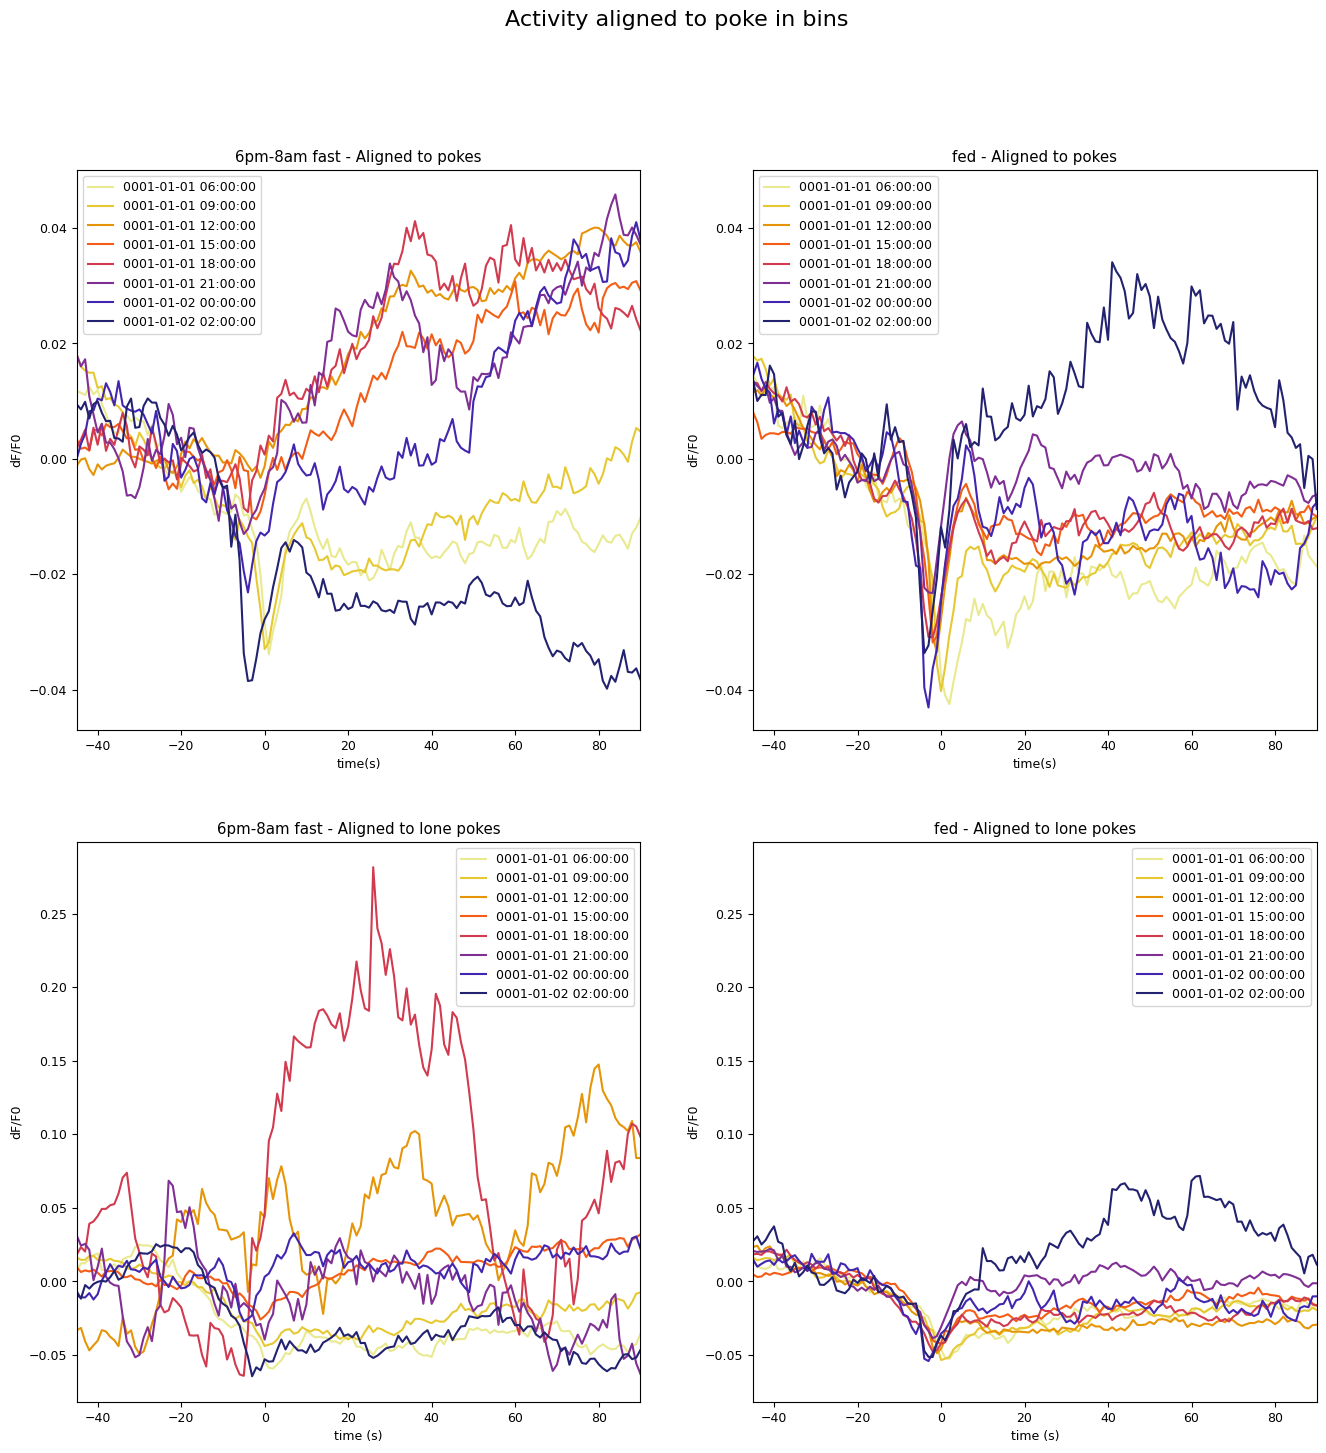

In [33]:
# define the bins - average all pokes within each bin (all bins are 3 hours, EXCEPT for day 2 ZT0-2, because food is returned at ZT2)
interval_starts = [datetime.datetime(1,1,1,6,0,0),datetime.datetime(1,1,1,9,0,0),datetime.datetime(1,1,1,12,0,0),
                   datetime.datetime(1,1,1,15,0,0),datetime.datetime(1,1,1,18,0,0),datetime.datetime(1,1,1,21,0,0),
                   datetime.datetime(1,1,2,0,0,0),datetime.datetime(1,1,2,2,0,0)]
interval_ends = [datetime.datetime(1,1,1,9,0,0),datetime.datetime(1,1,1,12,0,0),datetime.datetime(1,1,1,15,0,0),
                 datetime.datetime(1,1,1,18,0,0),datetime.datetime(1,1,1,21,0,0),datetime.datetime(1,1,2,0,0,0),
                 datetime.datetime(1,1,2,2,0,0),datetime.datetime(1,1,2,3,0,0)]

PokeTrig_Means = pd.DataFrame()
LonePokeTrig_Means = pd.DataFrame()
condlist = []
intlist = []

for Cond in ConditionsToPlot:  #loop through conditions
    for int_n in range(len(interval_starts)):   #loop through bins
        # select pokes and lone pokes that fall within the current bins
        pokes = AllTrials['Pokes_Pellets']['poke_activity']['dFF0'][[AllTrials['MouseTrialID'][ind] for ind,x
                                                                                        in enumerate(AllTrials['Condition']) if x == Cond]]
        These_Pokes = pokes[pokes.columns[pokes.columns.get_level_values(1) >= interval_starts[int_n]]]
        These_Pokes = These_Pokes[These_Pokes.columns[These_Pokes.columns.get_level_values(1) < interval_ends[int_n]]]
        
        These_Lone_Pokes = Lone_Pokes[Cond][Lone_Pokes[Cond].columns[Lone_Pokes[Cond].columns.get_level_values(2) >= interval_starts[int_n]]]
        These_Lone_Pokes = These_Lone_Pokes[These_Lone_Pokes.columns[These_Lone_Pokes.columns.get_level_values(2) < interval_ends[int_n]]]
        
        # take mean over pokes within this bin
        PokeTrig_Means = pd.concat([PokeTrig_Means,These_Pokes.mean(axis=1)],axis=1)
        LonePokeTrig_Means = pd.concat([LonePokeTrig_Means,These_Lone_Pokes.mean(axis=1)],axis=1)
        condlist.append(Cond)
        intlist.append(interval_starts[int_n])
        
# make column titles
arrays = [condlist,intlist]
tuples = list(zip(*arrays))
index = pd.MultiIndex.from_tuples(tuples, names=["Condition","Interval Start"])
PokeTrig_Means.columns = index
LonePokeTrig_Means.columns = index

## Plot means for each condition
fig,axs = plt.subplots(2,len(ConditionsToPlot),figsize=(16,16))
# create color palette - changing shades for each interval
colpal = sns.color_palette("CMRmap_r",len(interval_starts))
n=0
for Cond in ConditionsToPlot:
    # plot mean over pokes on left axes, and set axis properties
    axs[0,n].set_prop_cycle('color', colpal)
    axs[0,n].plot(PokeTrig_Means[Cond])
    axs[0,n].set(xlabel="time(s)", ylabel="dF/F0", title=Cond+' - Aligned to pokes')
    axs[0,n].legend(PokeTrig_Means[Cond].columns)

    # plot mean over lone pokes on right axes, and set axis properties
    axs[1,n].set_prop_cycle('color', colpal)
    axs[1,n].plot(LonePokeTrig_Means[Cond])
    axs[1,n].set(xlabel="time (s)", ylabel="dF/F0", title=Cond+' - Aligned to lone pokes')
    axs[1,n].legend(LonePokeTrig_Means[Cond].columns)
    n=n+1

# set y limits equal on each set of plots
lower_y = [ax.get_ylim()[0] for ax in axs[0,:]]
upper_y = [ax.get_ylim()[1] for ax in axs[0,:]]
[ax.set_ylim(min(lower_y),max(upper_y)  ) for ax in axs[0,:]]
lower_y = [ax.get_ylim()[0] for ax in axs[1,:]]
upper_y = [ax.get_ylim()[1] for ax in axs[1,:]]
[ax.set_ylim(min(lower_y),max(upper_y)  ) for ax in axs[1,:]]

fig.suptitle('Activity aligned to poke in bins', fontsize=16)

# save figure in png and svg formats
fig.savefig('Poke-aligned activity mean over pokes in bins.png',facecolor="white")
fig.savefig('Poke-aligned activity mean over pokes in bins.svg',facecolor="white")

# Aligning neural activity to different events at the start of fasting
At the start of fasting, neural activity increases. We hypothesize that this increase in activity could be driven by 3 possible events:

1) the time when food becomes unavailable (ZT12)

2) the first time that the mouse pokes and does not receive a pellet

3) the time of peak poke rate - when the mouse is receiving the maximum amount of evidence that poking does not result in food delivery

As a test of this, let's align the neural activity to each of these events. For the start of fasting (1), we need to use the time from the FED3, not real-time.

In [34]:
# Set the time to plot before/after start of fast / first unrewarded poke
Pre_FastStart_Time = 2 #in hours
Post_FastStart_Time = 3 #in hours
# convert to timedelta
PreFastStartTime = datetime.timedelta(hours = Pre_FastStart_Time)
PostFastStartTime = datetime.timedelta(hours = Post_FastStart_Time)

Aligned = {'ZT12':{}, 'FirstUnrewardedPoke':{},'PeakPokeRate':{},'FastStartToFirstPoke':{},'FirstUnrewardedPokeTime':{},'PeakTime':{},
                     'First3hPokes':{},'FastStartTime':{},'PokeRate':{}}

# recalculate rolling poke rate using smaller window (5mins)
Aligned['PokeRate'] = AllTrials['Pokes_Pellets']['pokes_cum_ts'].diff().rolling(window = 60*5, center=False).mean()*5

# loop through conditions and then trials, and align activity to each event
for Cond in ConditionsToPlot:
    Aligned['ZT12'][Cond] = pd.DataFrame()
    Aligned['FirstUnrewardedPoke'][Cond] = pd.DataFrame()
    Aligned['PeakPokeRate'][Cond] = pd.DataFrame()
    Aligned['FastStartToFirstPoke'][Cond] = []
    Aligned['FirstUnrewardedPokeTime'][Cond] = []
    Aligned['PeakTime'][Cond] = []
    Aligned['First3hPokes'][Cond] = {}
    Aligned['FastStartTime'][Cond] = []
    # loop through trials for this condition
    for Trial in Moving_Means[10]['z-score'].xs(Cond,level='Stim',axis=1).columns.get_level_values(1):
        index = pd.MultiIndex.from_product([[Stim],[Trial]],names = ['Cond','MouseTrialID'])
        # need to align to FED time, not real time. So get FED clock offset for this trial
        idx = AllTrials['MouseTrialID'].index(Trial)
        Offset = AllTrials['FEDClockOffset'][idx]
        ThisTrial_Activity = Moving_Means[10]['z-score'].xs(Trial,level='MouseTrialID',axis=1)
        # now align MM10_ZS activity to ZT12 on FED clock
        FastStartTime = datetime.datetime(1,1,1,12,0,0) - Offset
        PreTime = FastStartTime - PreFastStartTime
        PostTime = FastStartTime + PostFastStartTime
        ThisTrial_AlignedToZT12 = ThisTrial_Activity.loc[date_range(PreTime,PostTime,1,"seconds")]
        ThisTrial_AlignedToZT12.index = list(range(0-Pre_FastStart_Time*60*60,0+Post_FastStart_Time*60*60+1))
        ThisTrial_AlignedToZT12.columns = index
        
        # get the time of the first unrewarded poke for this trial
        PokeTimes = list(AllTrials['Pokes_Pellets']['poke_activity']['raw'].xs(Trial,level=0,axis=1).columns)
        FirstUnrewardedPokeTime = PokeTimes[[i > FastStartTime for i in PokeTimes].index(True)]
        # and the times of all the pokes in the first 3 hours of fasting
        First3hPokes = [i for i in PokeTimes if i > FastStartTime and i < FastStartTime+datetime.timedelta(hours=3)]
        First3hPokes = [j.seconds for j in [i - FastStartTime for i in First3hPokes]]
        # change indices to be relative to first unrewarded poke in FED clock
        PreTime = FirstUnrewardedPokeTime - PreFastStartTime
        PostTime = FirstUnrewardedPokeTime + PostFastStartTime
        ThisTrial_AlignedToFirstUnrewardedPoke = ThisTrial_Activity.loc[date_range(PreTime,PostTime,1,"seconds")]
        ThisTrial_AlignedToFirstUnrewardedPoke.index = list(range(0-Pre_FastStart_Time*60*60,0+Post_FastStart_Time*60*60+1))
        ThisTrial_AlignedToFirstUnrewardedPoke.columns = index

        # find peak poke rate between ZT12 and ZT2, and get activity relative to this time
        PeakTime = Aligned['PokeRate'][Cond,Trial][date_range(datetime.datetime(1,1,1,12,0),datetime.datetime(1,1,2,2,0),1,'seconds')].idxmax()
        PreTime = PeakTime - PreFastStartTime
        if PreTime < ThisTrial_Activity.index[0]:
            PreTime = ThisTrial_Activity.index[0]
        PostTime = PeakTime + PostFastStartTime
        if PostTime > ThisTrial_Activity.index[-1]:
            PostTime = ThisTrial_Activity.index[-1]
        
        ThisTrial_AlignedToPeakPokeRate = ThisTrial_Activity.loc[date_range(PreTime,PostTime,1,"seconds")]
        if PreTime == ThisTrial_Activity.index[0]:
            ThisTrial_AlignedToPeakPokeRate.index = list(range(0-(PeakTime - ThisTrial_Activity.index[0]).seconds,0+Post_FastStart_Time*60*60+1))
        elif PostTime == ThisTrial_Activity.index[-1]:
            ThisTrial_AlignedToPeakPokeRate.index = list(range(0-Pre_FastStart_Time*60*60,(ThisTrial_Activity.index[-1] - PeakTime).seconds))
        else:
            ThisTrial_AlignedToPeakPokeRate.index = list(range(0-Pre_FastStart_Time*60*60,1+Post_FastStart_Time*60*60))
        
        # save all of this to dict
        Aligned['ZT12'][Cond][Trial] = ThisTrial_AlignedToZT12
        Aligned['FirstUnrewardedPoke'][Cond][Trial] = ThisTrial_AlignedToFirstUnrewardedPoke
        Aligned['PeakPokeRate'][Cond][Trial] = ThisTrial_AlignedToPeakPokeRate
        Aligned['FastStartToFirstPoke'][Cond].append((FirstUnrewardedPokeTime - FastStartTime).seconds)
        Aligned['FirstUnrewardedPokeTime'][Cond].append(FirstUnrewardedPokeTime)
        Aligned['PeakTime'][Cond].append(PeakTime)
        Aligned['First3hPokes'][Cond][Trial] = First3hPokes
        Aligned['FastStartTime'][Cond].append(FastStartTime)

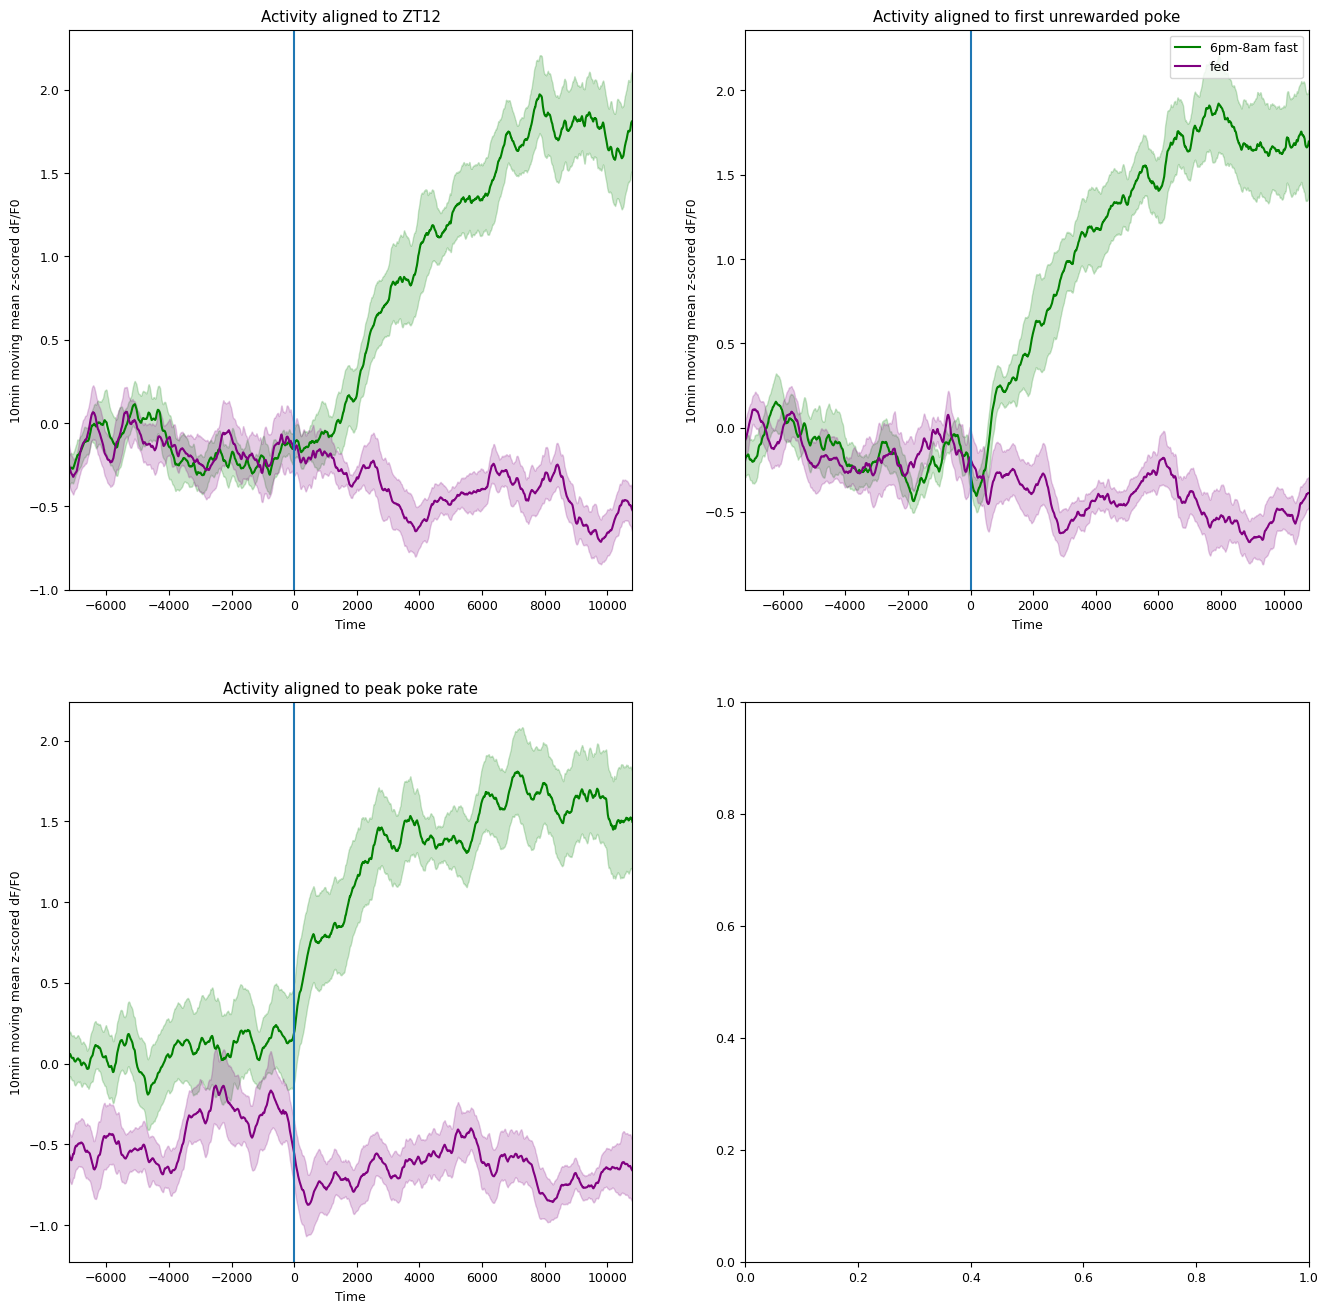

In [35]:
# Plot activity (MM10) aligned to each event

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(16,16))

n=0
for Cond in ConditionsToPlot:
    # plot average over trials aligned to ZT12
    ThisMean = Aligned['ZT12'][Cond].mean(axis=1)
    ThisSEM = Aligned['ZT12'][Cond].sem(axis=1)
    ax1.plot(ThisMean,color=ColorsToUse[n],label=Cond)
    ax1.fill_between(Aligned['ZT12'][Cond].index,ThisMean.subtract(ThisSEM,fill_value=0),ThisMean.add(ThisSEM,fill_value=0),
                     color=ColorsToUse[n],alpha=0.2)
    # plot average over trials aligned to first unrewarded poke
    ThisMean = Aligned['FirstUnrewardedPoke'][Cond].mean(axis=1)
    ThisSEM = Aligned['FirstUnrewardedPoke'][Cond].sem(axis=1)
    ax2.plot(ThisMean,color=ColorsToUse[n],label=Cond)
    ax2.fill_between(Aligned['FirstUnrewardedPoke'][Cond].index,ThisMean.subtract(ThisSEM,fill_value=0),ThisMean.add(ThisSEM,fill_value=0),
                     color=ColorsToUse[n],alpha=0.2)
    # plot average over trials aligned to peak poke rate
    ThisMean = Aligned['PeakPokeRate'][Cond].mean(axis=1)
    ThisSEM = Aligned['PeakPokeRate'][Cond].sem(axis=1)
    ax3.plot(ThisMean,color=ColorsToUse[n],label=Cond)
    ax3.fill_between(Aligned['PeakPokeRate'][Cond].index,ThisMean.subtract(ThisSEM,fill_value=0),ThisMean.add(ThisSEM,fill_value=0),
                     color=ColorsToUse[n],alpha=0.2)
    n=n+1

# add vertical line at event time (t=0) and add labels
for ax in [ax1,ax2,ax3]:
    ax.axvline(x=0)
    ax.set_ylabel('10min moving mean z-scored dF/F0')
    ax.set_xlabel('Time')
ax1.set_title('Activity aligned to ZT12')
ax2.set_title('Activity aligned to first unrewarded poke')
ax3.set_title('Activity aligned to peak poke rate')

ax2.legend()

figname = "MM10 aligned to fast start"
plt.savefig(figname+'.svg')
plt.savefig(figname+'.png')

The measure of activity here ("MM10") has two issues: 1) it is averaged over a fairly long period (10 minutes), so misses fast fluctuations in signal; and 2) it is normalized to a period early in the trial. Instead, we want to normalize activity to the period right before the event of interest happens, in order to see changes that follow this event of interest. Let's do this.

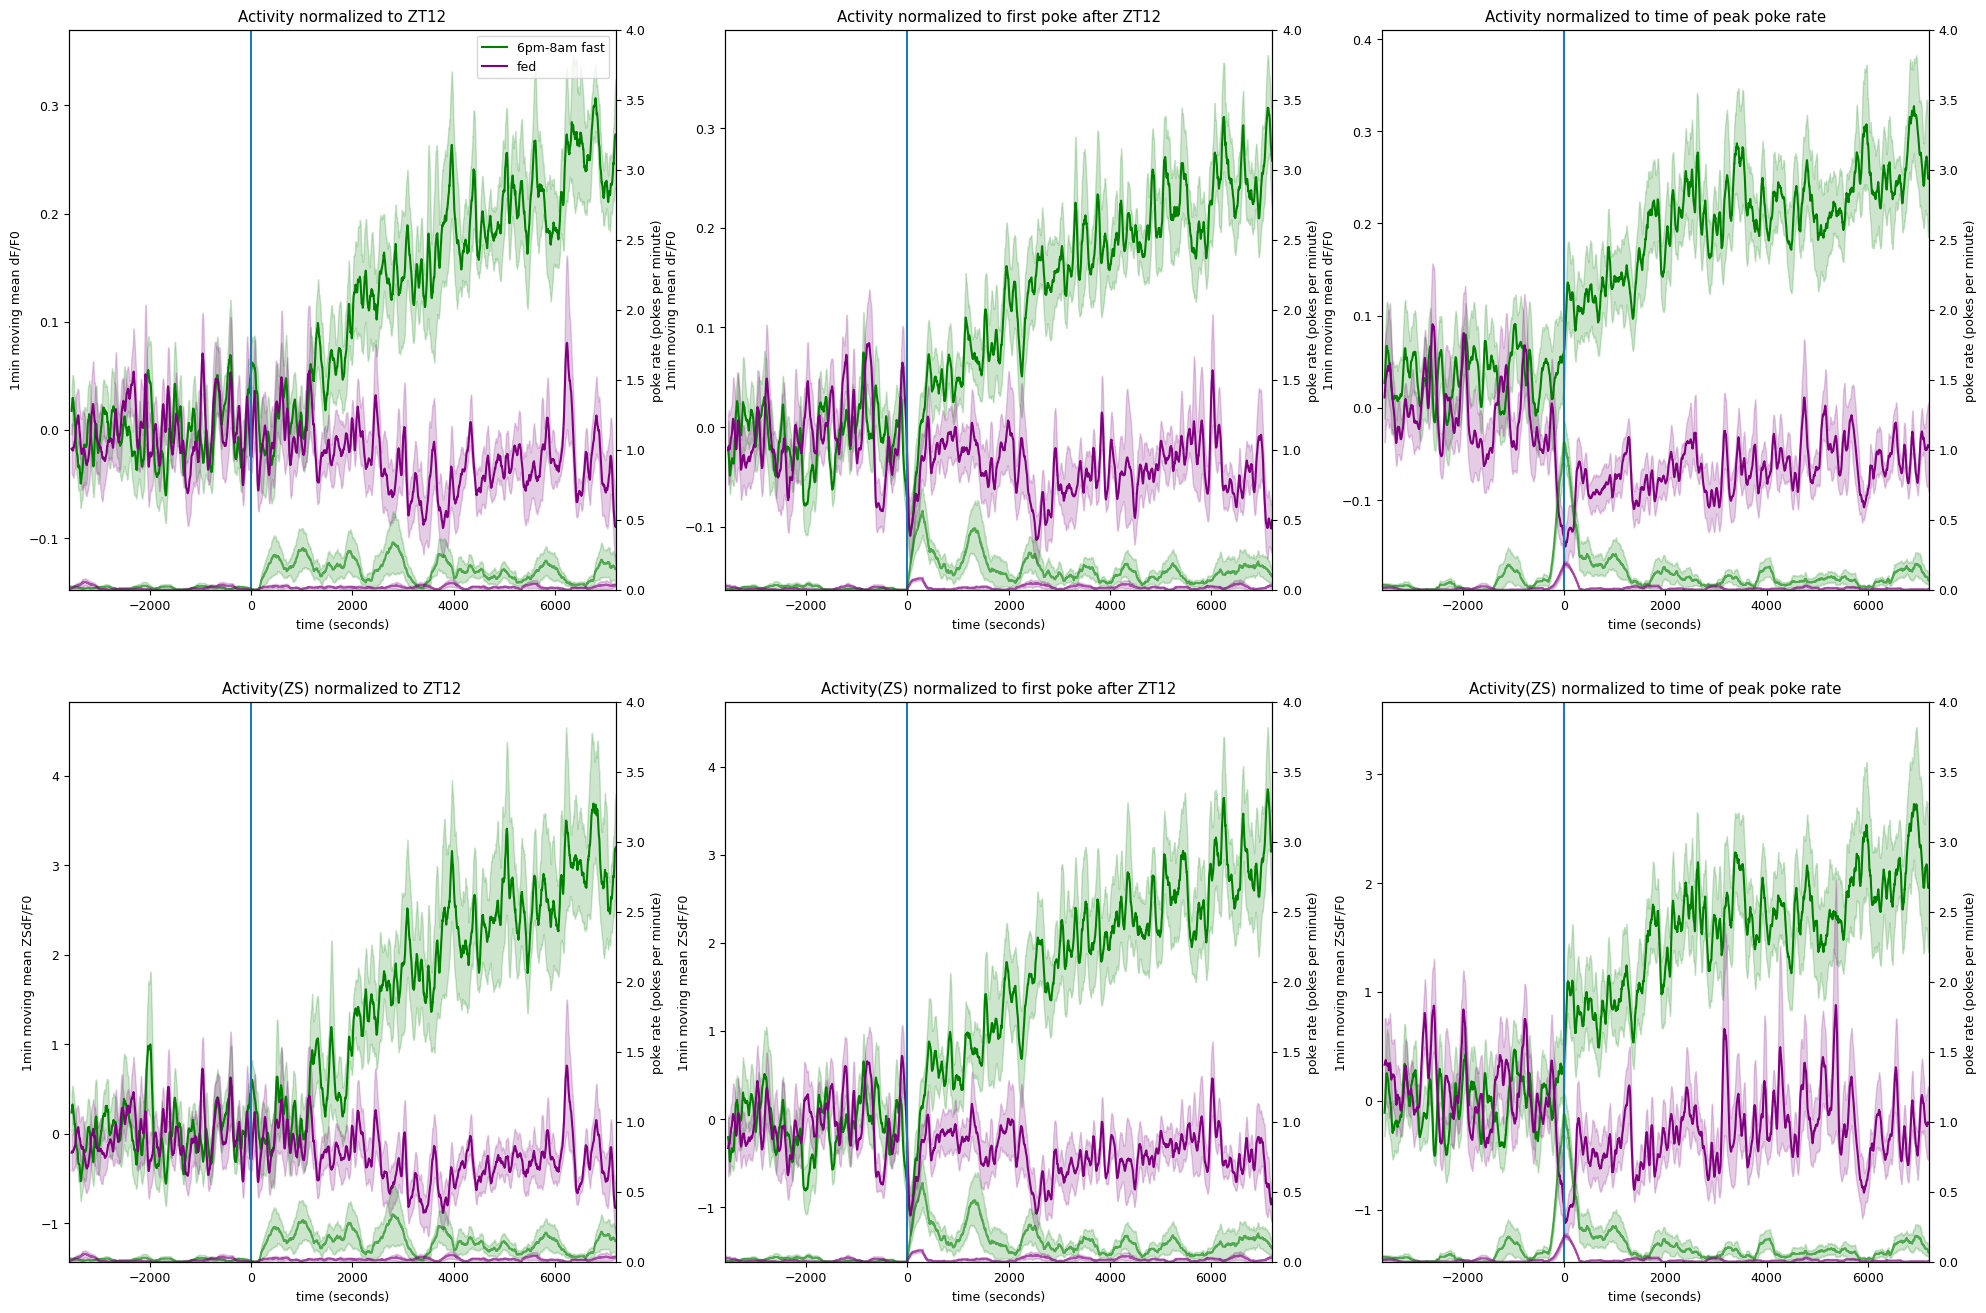

In [38]:
# Instead of using z-scored dF/F0 over the first x hours of trial, instead calculate dF/F0 using F0 in the time
# prior to the start of fasting or prior to the first unrewarded poke

F0Time = 30 #mins before poke to take to calculate F0
Pre_FastStart_Time = 1 # in hours
Post_FastStart_Time = 2
PreFastStartTime = datetime.timedelta(seconds=Pre_FastStart_Time*60*60)
PostFastStartTime = datetime.timedelta(seconds=Post_FastStart_Time*60*60)

Traces = ['dFF0_FirstUnrewardedPoke', 'ZS_FirstUnrewardedPoke','dFF0_FastStart', 'ZS_FastStart', 'dFF0_PeakPokeRate', 'ZS_PeakPokeRate',
          'PokeRateFP', 'PokeRateFS', 'PokeRatePPR']
for i in Traces:
    Aligned[i] = {}

# loop through conditions and trials
for Cond in ConditionsToPlot:
    t=-1
    for i in Traces:
        Aligned[i][Cond] = pd.DataFrame()
    for Trial in list(Aligned['FirstUnrewardedPoke'][Cond].columns):
        t=t+1
        # get time of first unrewarded poke and fast start
        FirstURPokeTime = Aligned['FirstUnrewardedPokeTime'][Cond][t]
        FastStart = Aligned['FastStartTime'][Cond][t]
        PeakTime = Aligned['PeakTime'][Cond][t]
        # calculate dF/F0 relative to first unrewarded poke
        Trace = AllTrials['Raw_DS'].xs(Trial,level='MouseTrialID',axis=1).loc[date_range(FirstURPokeTime-PreFastStartTime,
            FirstURPokeTime+PostFastStartTime,1,'seconds')].iloc[:,0]
        Trace.index = list(range(0-Pre_FastStart_Time*60*60,1+Post_FastStart_Time*60*60))
        F0 = Trace.loc[list(range(0-(60*F0Time),0-60))].mean(axis=0)
        dFF0_Trace = pd.DataFrame([(i-F0)/F0 for i in Trace], index=Trace.index, columns=[Trial])
        # calculate z-score
        MN = dFF0_Trace[Trial][list(range(0-(60*F0Time),0-60))].mean(axis=0)
        STD = dFF0_Trace[Trial][list(range(0-(60*F0Time),0-60))].std(axis=0)
        ZS_Trace = pd.DataFrame((dFF0_Trace[Trial] - MN)/STD, index=dFF0_Trace.index, columns=[Trial])
        # take rolling mean
        dFF0_Rolling = dFF0_Trace.rolling(window=60, center=False).mean()
        ZS_Rolling = ZS_Trace.rolling(window=60, center=False).mean()
        # add to dataframe
        Aligned['dFF0_FirstUnrewardedPoke'][Cond] = pd.concat([Aligned['dFF0_FirstUnrewardedPoke'][Cond],dFF0_Rolling],axis=1)
        Aligned['ZS_FirstUnrewardedPoke'][Cond] = pd.concat([Aligned['ZS_FirstUnrewardedPoke'][Cond],ZS_Rolling],axis=1)
        # align poke rate to first poke
        PokeRate = Aligned['PokeRate'][Cond,Trial][date_range(FirstURPokeTime-PreFastStartTime,
            FirstURPokeTime+PostFastStartTime,1,'seconds')]
        PokeRate.name = PokeRate.name[1]
        PokeRate.index = list(range(0-Pre_FastStart_Time*60*60,1+Post_FastStart_Time*60*60))
        Aligned['PokeRateFP'][Cond] = pd.concat([Aligned['PokeRateFP'][Cond],PokeRate],axis=1)
        
        # do same relative to fast start
        TraceFS = AllTrials['Raw_DS'].xs(Trial,level='MouseTrialID',axis=1).loc[date_range(FastStart-PreFastStartTime,
            FastStart+PostFastStartTime,1,'seconds')].iloc[:,0]
        TraceFS.index = list(range(0-Pre_FastStart_Time*60*60,1+Post_FastStart_Time*60*60))
        F0_FS = TraceFS.loc[list(range(0-(60*F0Time),0-60))].mean(axis=0)
        dFF0_TraceFS = pd.DataFrame([(i-F0_FS)/F0_FS for i in TraceFS], index=TraceFS.index, columns=[Trial])
        # calculate z-score
        MN = dFF0_TraceFS[Trial][list(range(0-(60*F0Time),0-60))].mean(axis=0)
        STD = dFF0_TraceFS[Trial][list(range(0-(60*F0Time),0-60))].std(axis=0)
        ZS_TraceFS = pd.DataFrame((dFF0_TraceFS[Trial] - MN)/STD, index=dFF0_TraceFS.index, columns=[Trial])
        # take rolling mean
        dFF0_Rolling_FS = dFF0_TraceFS.rolling(window=60, center=False).mean()
        ZS_Rolling_FS = ZS_TraceFS.rolling(window=60, center=False).mean()
        # add to dataframe
        Aligned['dFF0_FastStart'][Cond] = pd.concat([Aligned['dFF0_FastStart'][Cond],dFF0_Rolling_FS],axis=1)
        Aligned['ZS_FastStart'][Cond] = pd.concat([Aligned['ZS_FastStart'][Cond],ZS_Rolling_FS],axis=1)
        # align poke rate to fast start
        PokeRate_FS = Aligned['PokeRate'][Cond,Trial][date_range(FastStart-PreFastStartTime,
            FastStart+PostFastStartTime,1,'seconds')]
        PokeRate_FS.name = PokeRate_FS.name[1]
        PokeRate_FS.index = list(range(0-Pre_FastStart_Time*60*60,1+Post_FastStart_Time*60*60))
        Aligned['PokeRateFS'][Cond] = pd.concat([Aligned['PokeRateFS'][Cond],PokeRate_FS],axis=1)

        # do same relative to time of peak poke rate
        TracePPR = AllTrials['Raw_DS'].xs(Trial,level='MouseTrialID',axis=1).loc[date_range(PeakTime-PreFastStartTime,
            PeakTime+PostFastStartTime,1,'seconds')].iloc[:,0]
        TracePPR.index = list(range(0-Pre_FastStart_Time*60*60,1+Post_FastStart_Time*60*60))
        F0_PPR = TracePPR.loc[list(range(0-(60*F0Time),0-60))].mean(axis=0)
        dFF0_TracePPR = pd.DataFrame([(i-F0_FS)/F0_FS for i in TracePPR], index=TracePPR.index, columns=[Trial])
        # calculate z-score
        MN = dFF0_TracePPR[Trial][list(range(0-(60*F0Time),0-60))].mean(axis=0)
        STD = dFF0_TracePPR[Trial][list(range(0-(60*F0Time),0-60))].std(axis=0)
        ZS_TracePPR = pd.DataFrame((dFF0_TracePPR[Trial] - MN)/STD, index=dFF0_TracePPR.index, columns=[Trial])
        # take rolling mean
        dFF0_Rolling_PPR = dFF0_TracePPR.rolling(window=60, center=False).mean()
        ZS_Rolling_PPR = ZS_TracePPR.rolling(window=60, center=False).mean()
        # add to dataframe
        Aligned['dFF0_PeakPokeRate'][Cond] = pd.concat([Aligned['dFF0_PeakPokeRate'][Cond],dFF0_Rolling_PPR],axis=1)
        Aligned['ZS_PeakPokeRate'][Cond] = pd.concat([Aligned['ZS_PeakPokeRate'][Cond],ZS_Rolling_PPR],axis=1)
        # align poke rate to peak
        PokeRate_PPR = Aligned['PokeRate'][Cond,Trial][date_range(PeakTime-PreFastStartTime,
            PeakTime+PostFastStartTime,1,'seconds')]
        PokeRate_PPR.name = PokeRate_PPR.name[1]
        PokeRate_PPR.index = list(range(0-Pre_FastStart_Time*60*60,1+Post_FastStart_Time*60*60))
        Aligned['PokeRatePPR'][Cond] = pd.concat([Aligned['PokeRatePPR'][Cond],PokeRate_PPR],axis=1)
        
# plot mean over trials - neural activity AND poke rate in same plot
fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(24,16))
ax7 = ax1.twinx()
ax8 = ax2.twinx()
ax9 = ax3.twinx()
ax10 = ax4.twinx()
ax11 = ax5.twinx()
ax12 = ax6.twinx()
n=0
for Cond in ConditionsToPlot:
    # plot dF/F0 aligned to fast start
    ThisMean = Aligned['dFF0_FastStart'][Cond].mean(axis=1)
    ThisSEM = Aligned['dFF0_FastStart'][Cond].sem(axis=1)
    ax1.plot(ThisMean,color=ColorsToUse[n],label=Cond)
    ax1.fill_between(Aligned['dFF0_FastStart'][Cond].index, ThisMean.subtract(ThisSEM,fill_value=0),
                     ThisMean.add(ThisSEM,fill_value=0),color=ColorsToUse[n],alpha=0.2)
    ThisMean_PR = Aligned['PokeRateFS'][Cond].mean(axis=1)
    ThisSEM_PR = Aligned['PokeRateFS'][Cond].sem(axis=1)
    ax7.plot(ThisMean_PR,color=ColorsToUse[n],alpha=0.6)
    if len(Aligned['PokeRateFS'][Cond].columns)>1:
        ax7.fill_between(Aligned['PokeRateFS'][Cond].index.tolist(), ThisMean_PR.subtract(ThisSEM_PR,fill_value=0),
                         ThisMean_PR.add(ThisSEM_PR,fill_value=0),color=ColorsToUse[n],alpha=0.2)

    # plot dF/F0 aligned to first unrewarded poke
    ThisMean = Aligned['dFF0_FirstUnrewardedPoke'][Cond].mean(axis=1)
    ThisSEM = Aligned['dFF0_FirstUnrewardedPoke'][Cond].sem(axis=1)
    ax2.plot(ThisMean,color=ColorsToUse[n],label=Cond)
    ax2.fill_between(Aligned['dFF0_FirstUnrewardedPoke'][Cond].index, ThisMean.subtract(ThisSEM,fill_value=0),
                     ThisMean.add(ThisSEM,fill_value=0),color=ColorsToUse[n],alpha=0.2)
    ThisMean_PR1 = Aligned['PokeRateFP'][Cond].mean(axis=1)
    ThisSEM_PR1 = Aligned['PokeRateFP'][Cond].sem(axis=1)
    ax8.plot(ThisMean_PR1,color=ColorsToUse[n],alpha=0.6)
    if len(Aligned['PokeRateFP'][Cond].columns)>1:
        ax8.fill_between(Aligned['PokeRateFP'][Cond].index.tolist(), ThisMean_PR1.subtract(ThisSEM_PR1,fill_value=0),
                         ThisMean_PR1.add(ThisSEM_PR1,fill_value=0),color=ColorsToUse[n],alpha=0.2)

    # plot dF/F0 aligned to time of peak poke rate
    ThisMean = Aligned['dFF0_PeakPokeRate'][Cond].mean(axis=1)
    ThisSEM = Aligned['dFF0_PeakPokeRate'][Cond].sem(axis=1)
    ax3.plot(ThisMean,color=ColorsToUse[n],label=Cond)
    ax3.fill_between(Aligned['dFF0_PeakPokeRate'][Cond].index, ThisMean.subtract(ThisSEM,fill_value=0),
                     ThisMean.add(ThisSEM,fill_value=0),color=ColorsToUse[n],alpha=0.2)
    ThisMean_PR2 = Aligned['PokeRatePPR'][Cond].mean(axis=1)
    ThisSEM_PR2 = Aligned['PokeRatePPR'][Cond].sem(axis=1)
    ax9.plot(ThisMean_PR2,color=ColorsToUse[n],alpha=0.6)
    if len(Aligned['PokeRatePPR'][Cond].columns)>1:
        ax9.fill_between(Aligned['PokeRatePPR'][Cond].index.tolist(), ThisMean_PR2.subtract(ThisSEM_PR2,fill_value=0),
                         ThisMean_PR2.add(ThisSEM_PR2,fill_value=0),color=ColorsToUse[n],alpha=0.2)
    
    # plot z-score aligned to fast start
    ThisMean = Aligned['ZS_FastStart'][Cond].mean(axis=1)
    ThisSEM = Aligned['ZS_FastStart'][Cond].sem(axis=1)
    ax4.plot(ThisMean,color=ColorsToUse[n],label=Cond)
    ax4.fill_between(Aligned['ZS_FastStart'][Cond].index, ThisMean.subtract(ThisSEM,fill_value=0),
                     ThisMean.add(ThisSEM,fill_value=0),color=ColorsToUse[n],alpha=0.2)
    ax10.plot(ThisMean_PR,color=ColorsToUse[n],alpha=0.6)
    if len(Aligned['PokeRateFS'][Cond].columns)>1:
        ax10.fill_between(Aligned['PokeRateFS'][Cond].index.tolist(), ThisMean_PR.subtract(ThisSEM_PR,fill_value=0),
                         ThisMean_PR.add(ThisSEM_PR,fill_value=0),color=ColorsToUse[n],alpha=0.2)

    # plot z-score aligned to first unrewarded poke
    ThisMean = Aligned['ZS_FirstUnrewardedPoke'][Cond].mean(axis=1)
    ThisSEM = Aligned['ZS_FirstUnrewardedPoke'][Cond].sem(axis=1)
    ax5.plot(ThisMean,color=ColorsToUse[n],label=Cond)
    ax5.fill_between(Aligned['ZS_FirstUnrewardedPoke'][Cond].index, ThisMean.subtract(ThisSEM,fill_value=0),
                     ThisMean.add(ThisSEM,fill_value=0),color=ColorsToUse[n],alpha=0.2)
    ax11.plot(ThisMean_PR1,color=ColorsToUse[n],alpha=0.6)
    if len(Aligned['PokeRateFP'][Cond].columns)>1:
        ax11.fill_between(Aligned['PokeRateFP'][Cond].index.tolist(), ThisMean_PR1.subtract(ThisSEM_PR1,fill_value=0),
                         ThisMean_PR1.add(ThisSEM_PR1,fill_value=0),color=ColorsToUse[n],alpha=0.2)
    
    # plot z-score aligned to time of peak poke rate
    ThisMean = Aligned['ZS_PeakPokeRate'][Cond].mean(axis=1)
    ThisSEM = Aligned['ZS_PeakPokeRate'][Cond].sem(axis=1)
    ax6.plot(ThisMean,color=ColorsToUse[n],label=Cond)
    ax6.fill_between(Aligned['ZS_PeakPokeRate'][Cond].index, ThisMean.subtract(ThisSEM,fill_value=0),
                     ThisMean.add(ThisSEM,fill_value=0),color=ColorsToUse[n],alpha=0.2)
    ax12.plot(ThisMean_PR2,color=ColorsToUse[n],alpha=0.6)
    if len(Aligned['PokeRatePPR'][Cond].columns)>1:
        ax12.fill_between(Aligned['PokeRatePPR'][Cond].index.tolist(), ThisMean_PR2.subtract(ThisSEM_PR2,fill_value=0),
                         ThisMean_PR2.add(ThisSEM_PR2,fill_value=0),color=ColorsToUse[n],alpha=0.2)

    n=n+1

# add legend
ax1.legend()
# add line and x label
for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.axvline(x=0)
    ax.set_xlabel('time (seconds)')
for ax in [ax7,ax8,ax9,ax10,ax11,ax12]:
    ax.set_ylim([0,4])
    ax.set_ylabel('poke rate (pokes per minute)')

# add y label and title
ax1.set_ylabel('1min moving mean dF/F0')
ax2.set_ylabel('1min moving mean dF/F0')
ax3.set_ylabel('1min moving mean dF/F0')
ax4.set_ylabel('1min moving mean ZSdF/F0')
ax5.set_ylabel('1min moving mean ZSdF/F0')
ax6.set_ylabel('1min moving mean ZSdF/F0')
ax1.set_title('Activity normalized to ZT12')
ax2.set_title('Activity normalized to first poke after ZT12')
ax3.set_title('Activity normalized to time of peak poke rate')
ax4.set_title('Activity(ZS) normalized to ZT12')
ax5.set_title('Activity(ZS) normalized to first poke after ZT12')
ax6.set_title('Activity(ZS) normalized to time of peak poke rate')

figname = "Activity normalized and aligned to first poke after ZT12"

# save figure in svg and png formats
plt.savefig(figname+'.svg')
plt.savefig(figname+'.png')

Plot these same data showing each trial instead of averages, using a heatmap where each row is one trial

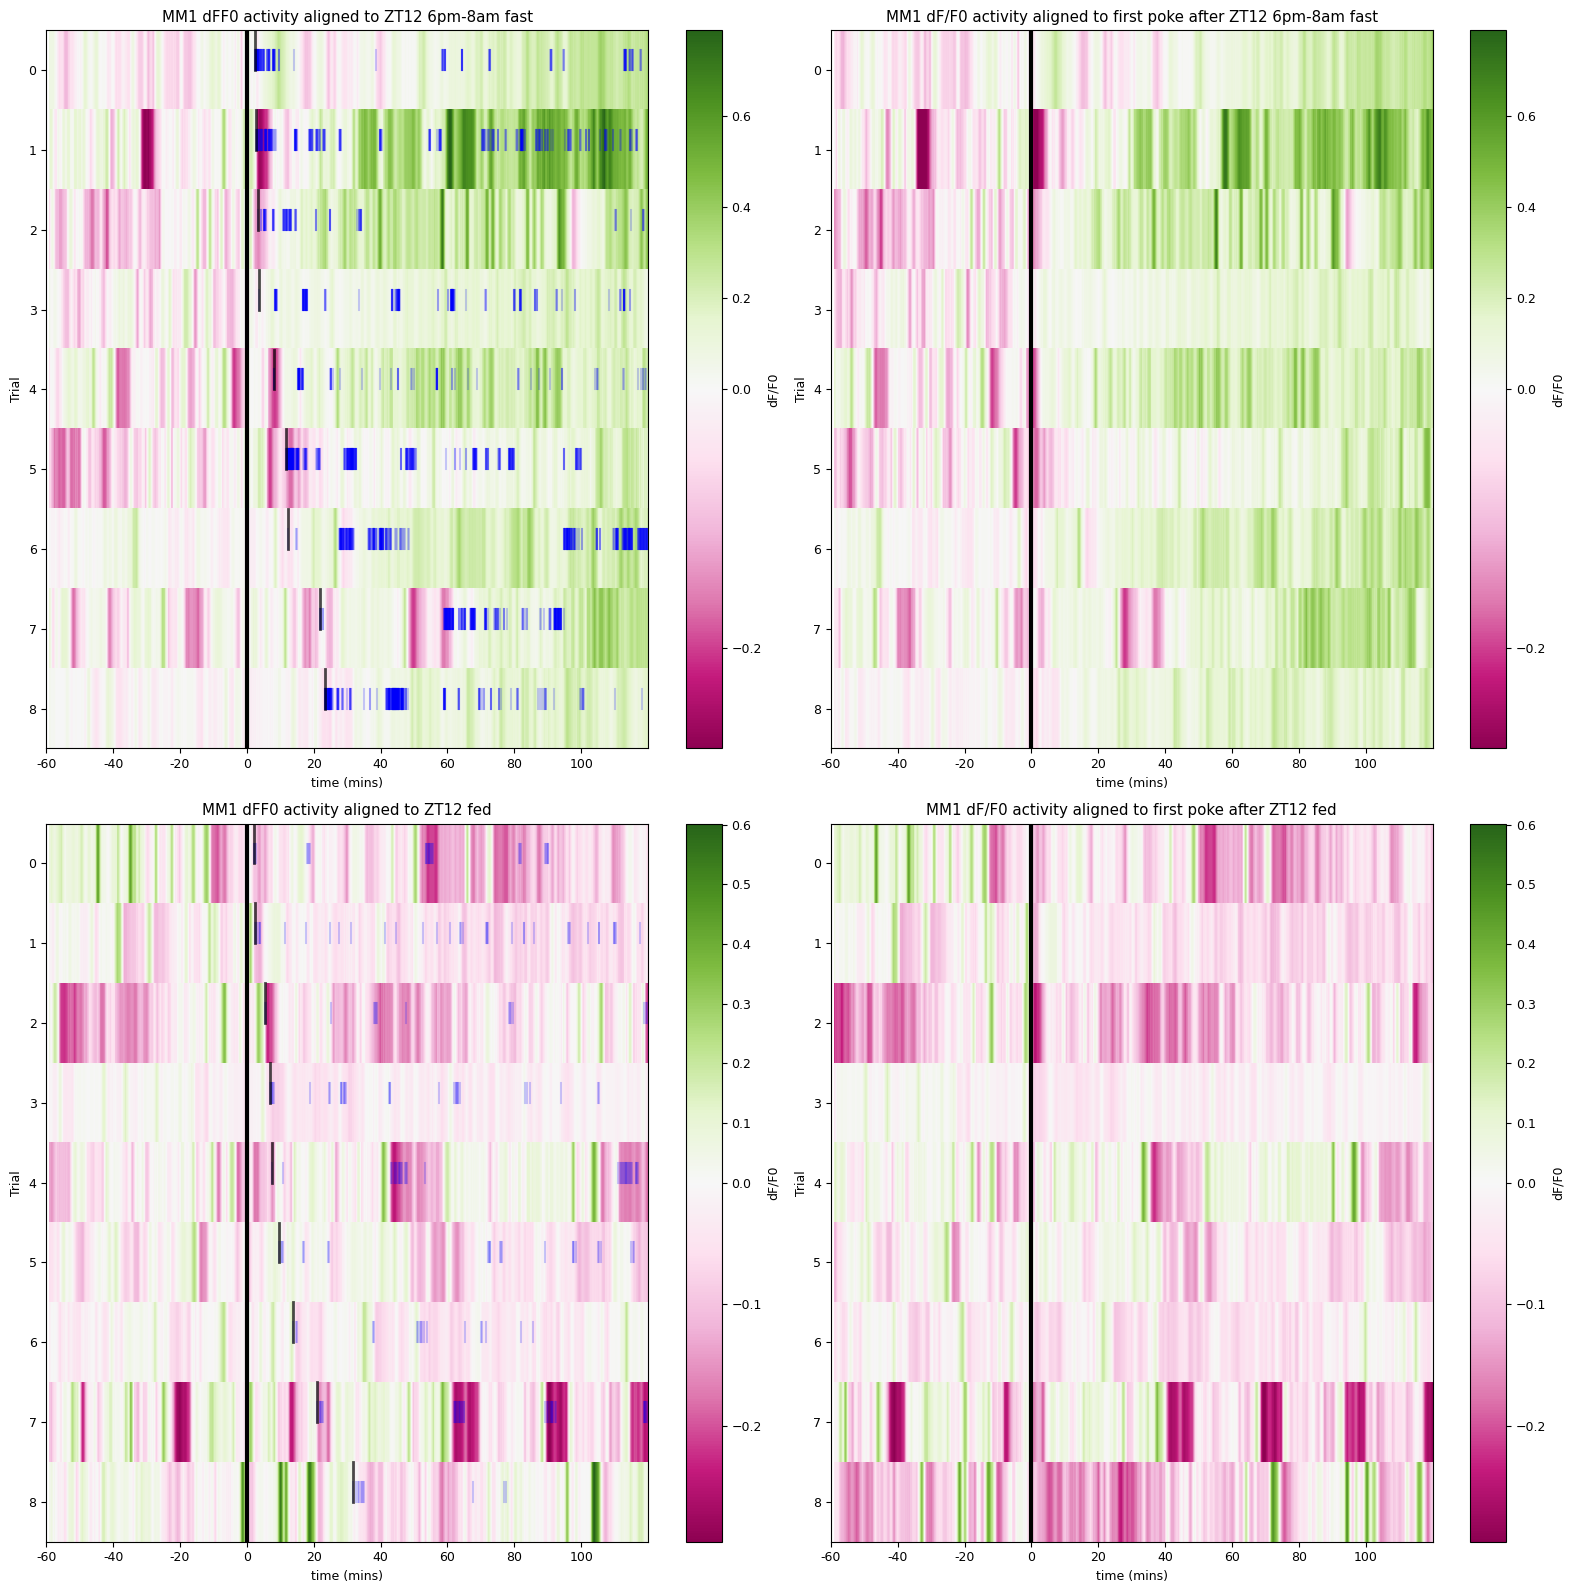

In [39]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(16,16))

n=-1
axnums = [ax1,ax3]
axnums2 = [ax2,ax4]
# make colormap
divnorm = colors.TwoSlopeNorm(vmin=np.min([Aligned['dFF0_FastStart'][i].min().min() for i in Aligned['dFF0_FastStart']]), vcenter=0,
                              vmax=np.max([Aligned['dFF0_FastStart'][i].max().max() for i in Aligned['dFF0_FastStart']]))

for Cond in ConditionsToPlot:
    n=n+1
    # first plot each trial aligned to fast start
    # sort trials according to time from fast start to first poke
    inds = np.array(Aligned['FastStartToFirstPoke'][Cond]).argsort()
    SortedTrials = Aligned['dFF0_FastStart'][Cond][[list(Aligned['dFF0_FastStart'][Cond].columns)[i] for i in list(inds)]]
    Sorted_PokeTimes = [Aligned['FastStartToFirstPoke'][Cond][i] for i in list(inds)]
    ThisAx = axnums[n]
    # make colormap
    divnorm = colors.TwoSlopeNorm(vmin=SortedTrials.min().min(), vcenter=0, vmax=SortedTrials.max().max())
    im = ThisAx.imshow(SortedTrials.transpose(),aspect='auto',interpolation='none',norm=divnorm,cmap='PiYG')
    # plot a line at ZT12
    ThisAx.axvline(x=Pre_FastStart_Time*60*60,color='black',lw=3)
    #now plot a tick at the time of every poke (in blue, alpha=0.2), and the first unrewarded poke (black, alpha=0.7)
    y=-1
    for Trial in SortedTrials.columns:
        y=y+1
        for poke in [i for i in Aligned['First3hPokes'][Cond][Trial] if i<=Post_FastStart_Time*60*60]:
            ThisAx.plot([Pre_FastStart_Time*60*60 + poke,Pre_FastStart_Time*60*60 + poke],[y-0.25,y],color='blue',alpha=0.2)
        ThisAx.plot([Pre_FastStart_Time*60*60 + Sorted_PokeTimes[y],Pre_FastStart_Time*60*60 + Sorted_PokeTimes[y]],[y-0.5,y],
                    color='black',alpha = 0.7,lw=2)
    # set axis properties
    ThisAx.set_xticks(range(0,SortedTrials.index[-1]-SortedTrials.index[0],60*20))
    ThisAx.set_xticklabels(range(int(SortedTrials.index[0]/60),int(SortedTrials.index[-1]/60),20))
    ThisAx.set(xlabel="time (mins)",
       ylabel="Trial",
       title="MM1 dFF0 activity aligned to ZT12 "+Cond)
    cbar = plt.colorbar(im,ax=ThisAx)
    cbar.set_label('dF/F0')
    fig.tight_layout()
    
    # now each trial aligned to first unrewarded poke
    ThisAx = axnums2[n]
    SortedTrials = Aligned['dFF0_FirstUnrewardedPoke'][Cond][[list(Aligned['dFF0_FirstUnrewardedPoke'][Cond].columns)[i] for i in list(inds)]]
    im = ThisAx.imshow(SortedTrials.transpose(),aspect='auto',interpolation='none',norm=divnorm,cmap='PiYG')
    ThisAx.set_xticks(range(0,SortedTrials.index[-1]-SortedTrials.index[0],60*20))
    ThisAx.set_xticklabels(range(int(SortedTrials.index[0]/60),int(SortedTrials.index[-1]/60),20))
    ThisAx.set(xlabel="time (mins)",
        ylabel="Trial",
       title="MM1 dF/F0 activity aligned to first poke after ZT12 "+Cond)
    # plot a line at ZT12
    ThisAx.axvline(x=Pre_FastStart_Time*60*60,color='black',lw=3)
    # add colorbar
    cbar = plt.colorbar(im,ax=ThisAx)
    cbar.set_label('dF/F0')
    fig.tight_layout()

figname = "Activity aligned to ZT12 or first poke"
plt.savefig(figname+'.svg')
plt.savefig(figname+'.png')

Since pokes come so close together, it's hard to tell on here what the poke rate looks like. Let's make a similar heatmap, but instead of plotting individual pokes, plot poke rate on each row of the heatmap.

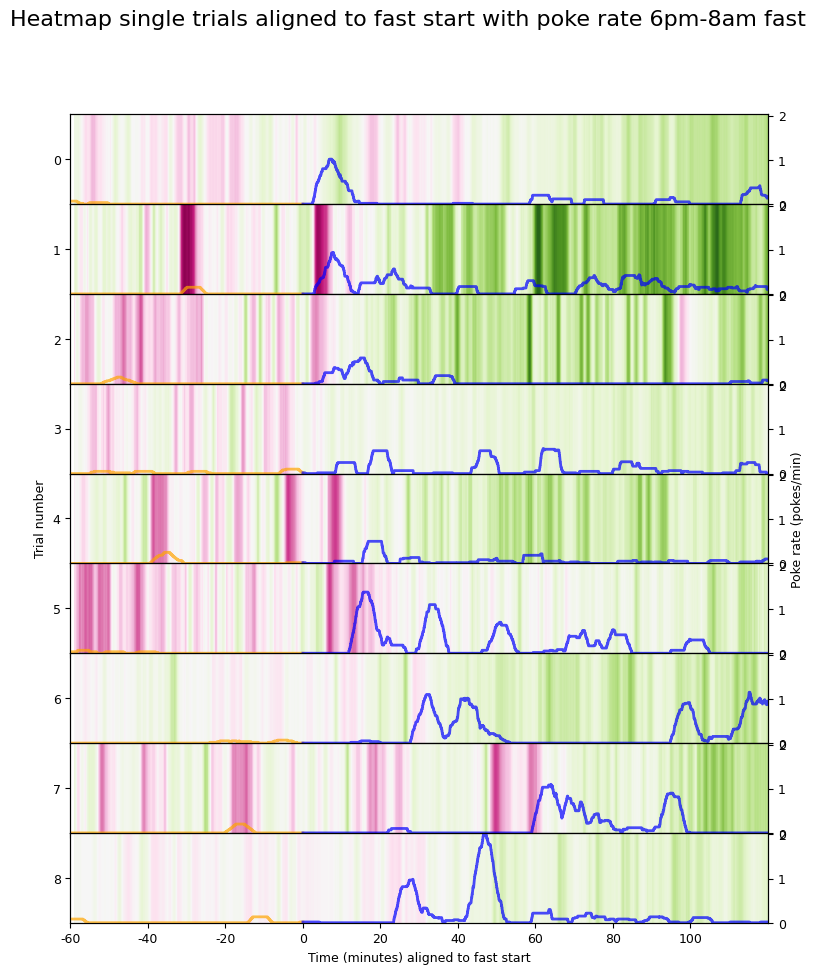

In [40]:
# note: this only works for more than one trial per condition
Cond = ConditionsToPlot[0] # which condition to plot
# select trials of interest
inds = np.array(Aligned['FastStartToFirstPoke'][Cond]).argsort()
SortedTrials = Aligned['dFF0_FastStart'][Cond][[list(Aligned['dFF0_FastStart'][Cond].columns)[i] for i in list(inds)]]
# create heatmap
divnorm = colors.TwoSlopeNorm(vmin=SortedTrials.min().min(), vcenter=0., vmax=SortedTrials.max().max())
# create axes - one set of axes per row
fig, axs = plt.subplots(nrows=len(list(SortedTrials.columns)), sharex=True, gridspec_kw={'hspace': 0})
# loop through trials, and plot one row of heatmap for this trial
for i, ax in enumerate(axs):
    Trial = list(SortedTrials.columns)[i]
    ax.imshow(SortedTrials.transpose().iloc[i:i + 1, :], aspect='auto', interpolation='none', cmap='PiYG', norm=divnorm)
    ax.set_yticks([0])
    ax.set_yticklabels(str(i))
    if i==round(len(axs)/2):
        ax.set_ylabel('Trial number')
    ax.set_xticks(range(0,SortedTrials.index[-1]-SortedTrials.index[0],60*20))
    ax.set_xticklabels(range(int(SortedTrials.index[0]/60),int(SortedTrials.index[-1]/60),20))
    ax2 = ax.twinx()
    # plot poke rate before ZT12 in orange and after ZT12 in blue
    range1 = list(range(SortedTrials.index[0],0))
    ax2.plot(list(range(0,len(range1))),np.array(Aligned['PokeRateFS'][Cond][Trial].loc[range1]), color="orange", linewidth=2, alpha=0.7)
    range2 = list(range(1,SortedTrials.index[-1]))
    ax2.plot(list(range(len(range1),len(range1)+len(range2))),np.array(Aligned['PokeRateFS'][Cond][Trial].loc[range2]),
                                                                        color="blue", linewidth=2, alpha=0.7)
    ax2.set_ylim([0,np.max([Aligned['PokeRateFS'][Cond].max().max() for Cond in Aligned['PokeRateFS']])])
    if i == round(len(axs)/2):
        ax2.set_ylabel('Poke rate (pokes/min)')

ax.set_xlabel('Time (minutes) aligned to fast start')

# save figure
figname = "Heatmap single trials aligned to fast start with poke rate " + Cond
fig.suptitle(figname, fontsize=16)
plt.savefig(figname+'.svg')
plt.savefig(figname+'.png')

As another way to test whether food-seeking (poking) behavior is driving the increase in neural activity, let's divide the trials into two groups, based on the first unrewarded poke time:

Group 1: <5 mins after ZT12

Group 2: >10 mins after ZT12

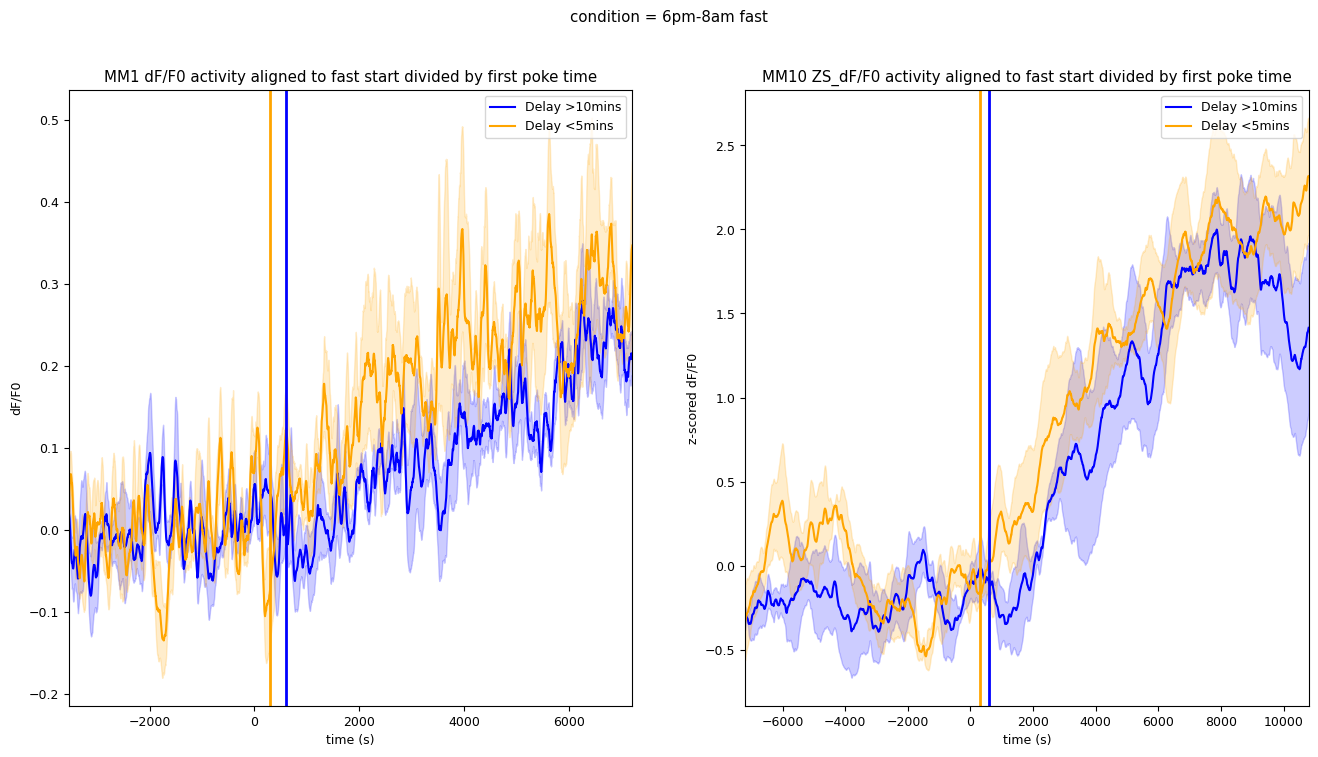

In [42]:
#Take traces where first poke time >10mins or <5mins after 6pm (use dFF0)
Under = 5 # group 1: first poke within less than this number of minutes
Over = 10 # group 2: first poke at least this number of minutes after lights-off
dFF0_Over = {}
MM10_Over = {}
dFF0_Over_Mean = pd.DataFrame()
MM10_Over_Mean = pd.DataFrame()
dFF0_Over_SEM = pd.DataFrame()
MM10_Over_SEM = pd.DataFrame()
dFF0_Under = {}
MM10_Under = {}
dFF0_Under_Mean = pd.DataFrame()
MM10_Under_Mean = pd.DataFrame()
dFF0_Under_SEM = pd.DataFrame()
MM10_Under_SEM = pd.DataFrame()

for Cond in list(Aligned['dFF0_FastStart'].keys()):
    dFF0_Over[Cond] = pd.DataFrame()
    TrialsOver = [i for i,v in enumerate(Aligned['FastStartToFirstPoke'][Cond]) if v/60 > Over]
    TrialsOver = [list(Aligned['dFF0_FastStart'][Cond].columns)[j] for j in TrialsOver]
    dFF0_Over[Cond] = Aligned['dFF0_FastStart'][Cond][TrialsOver]
    dFF0_Over_Mean[Cond] = dFF0_Over[Cond].mean(axis=1)
    dFF0_Over_SEM[Cond] = dFF0_Over[Cond].sem(axis=1)
    MM10_Over[Cond] = Aligned['ZT12'][Cond][TrialsOver]
    MM10_Over_Mean[Cond] = MM10_Over[Cond].mean(axis=1)
    MM10_Over_SEM[Cond] = MM10_Over[Cond].sem(axis=1)
    
    dFF0_Under[Stim] = pd.DataFrame()
    TrialsUnder = [i for i,v in enumerate(Aligned['FastStartToFirstPoke'][Cond]) if v/60 < Under]
    TrialsUnder = [list(Aligned['dFF0_FastStart'][Cond].columns)[j] for j in TrialsUnder]
    dFF0_Under[Cond] = Aligned['dFF0_FastStart'][Cond][TrialsUnder]
    dFF0_Under_Mean[Cond] = dFF0_Under[Cond].mean(axis=1)
    dFF0_Under_SEM[Cond] = dFF0_Under[Cond].sem(axis=1)
    MM10_Under[Cond] = Aligned['ZT12'][Cond][TrialsUnder]
    MM10_Under_Mean[Cond] = MM10_Under[Cond].mean(axis=1)
    MM10_Under_SEM[Cond] = MM10_Under[Cond].sem(axis=1)

condtoplot = ConditionsToPlot[0] # which condition to plot / 'FR1 6-8 fast'
# now plot
fig,((ax1,ax2)) = plt.subplots(1,2,figsize=(16,8))
ax1.plot(dFF0_Over_Mean[condtoplot],color='blue',label='Delay >'+str(Over)+'mins')
ax1.fill_between(dFF0_Over_Mean.index,dFF0_Over_Mean[condtoplot].subtract(dFF0_Over_SEM[condtoplot],fill_value=0),
                 dFF0_Over_Mean[condtoplot].add(dFF0_Over_SEM[condtoplot],fill_value=0),color='blue',alpha=0.2)
ax1.plot(dFF0_Under_Mean[condtoplot],color='orange',label='Delay <'+str(Under)+'mins')
ax1.fill_between(dFF0_Under_Mean.index,dFF0_Under_Mean[condtoplot].subtract(dFF0_Under_SEM[condtoplot],fill_value=0),
                 dFF0_Under_Mean[condtoplot].add(dFF0_Under_SEM[condtoplot],fill_value=0),color='orange',alpha=0.2)
ax1.legend()

ax2.plot(MM10_Over_Mean[condtoplot],color='blue',label='Delay >'+str(Over)+'mins')
ax2.fill_between(MM10_Over_Mean.index,MM10_Over_Mean[condtoplot].subtract(MM10_Over_SEM[condtoplot],fill_value=0),
                 MM10_Over_Mean[condtoplot].add(MM10_Over_SEM[condtoplot],fill_value=0),color='blue',alpha=0.2)
ax2.plot(MM10_Under_Mean[condtoplot],color='orange',label='Delay <'+str(Under)+'mins')
ax2.fill_between(MM10_Under_Mean.index,MM10_Under_Mean[condtoplot].subtract(MM10_Under_SEM[condtoplot],fill_value=0),
                 MM10_Under_Mean[condtoplot].add(MM10_Under_SEM[condtoplot],fill_value=0),color='orange',alpha=0.2)
ax2.legend()

ax1.set(xlabel="time (s)",
        ylabel="dF/F0",
       title="MM1 dF/F0 activity aligned to fast start divided by first poke time")
ax2.set(xlabel="time (s)",
        ylabel="z-scored dF/F0",
       title="MM10 ZS_dF/F0 activity aligned to fast start divided by first poke time")

ax1.axvline(x=5*60,color='orange',linewidth=2)
ax1.axvline(x=10*60,color='blue',linewidth=2)
ax2.axvline(x=5*60,color='orange',linewidth=2)
ax2.axvline(x=10*60,color='blue',linewidth=2)

fig.suptitle('condition = '+condtoplot)

# save figure as svg and png
figname = "Mean activity aligned to ZT12 divided by time to first poke " + condtoplot
plt.savefig(figname+'.svg')
plt.savefig(figname+'.png')